# Modeling
Iterative process to create a model that will reliably predict climbing grade based on the features we have available, primarily the text features. 

## Classification Using fastText API
Modified from [this fastText tutorial.](https://fasttext.cc/docs/en/supervised-tutorial.html) fastText was developed by Facebook to compete with more time-intensive deep learning approaches, and uses a [multinomial logistic regression algorithm](https://towardsdatascience.com/fasttext-bag-of-tricks-for-efficient-text-classification-513ba9e302e7). fastText is written in C++ and uses multithreading, so it was by far the fastest of the models I used. In addition, multinomial logistic regression does not assume independence the same way Naive Bayes does, making it a good algorithm for NLP. [This paper](https://aclanthology.org/E17-2068.pdf) has further discussion of the various tricks the fastText developers used to speed up their implementation, including hierarchical softmax to reduce computational complexity and "fast and memory efficient mapping of n-grams by using the hashing trick (Weinberger et al., 2009)". Generally, fastText works similarly to word2vec, averaging the weights of a single hidden layer to create document vectors, and then using those vectors as features for the multinomial logistic regression, which calculates the probability of the document belonging to each class. fastText is going to be our primary modeling focus.

## Sidenote: Transfer Learning
Given the small stature of the dataset, especially for an NLP problem, I wanted to implement a transfer learning approach as well.  BERT (Bidirectional Encoder Representations from Transformers) came up in my research as the classic, tried-and-true transfer learning approach. I chose the [bert-base-uncased model from Hugging Face](https://huggingface.co/bert-base-uncased), which is pre-trained on a masked language modeling task where 15% of each input is randomly masked, and the model predicts what those hidden words should be. In the transfer learning case, we add in an input layer of our data, and replace the output layer with the possible class labels. Essentially, the "masked" word from the BERT training becomes our label, which the model is then able to predict.

A few iterations were run on the BERT model, one example of which can be found in the BertBaseUncased notebook in the archive folder of this repo. Ultimately, the BERT model would take around 5 hours to train, and had no better results than fastText, which takes usually less than a minute. When it became clear that BERT performance could not justify the training time and resources used, I chose to narrow focus to other modeling methods.

## Imports and Load Data

In [ ]:
#optional installs used for running in colab
#!pip install fasttext
#!python -m spacy download en_core_web_lg

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import fasttext
import fasttext.util
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

np.random.seed(42)

In [2]:
#load in data
train = pd.read_csv("./data/train.csv")
val = pd.read_csv("./data/val.csv")
test = pd.read_csv("./data/test.csv")

## fastText Modeling Function
Because set pre-processing needs to be done for every run of the fastText model, and I planned to change the input text features as a best-bet for improving the modeling, I wanted to create a consistent function that could be run on the data each time. I am using the loss funtion "hs", or hierarchical softmax, because it runs faster.

In [3]:
def run_fasttext(train, val, test, target_col, x_cols, autotune=None, wordNgrams=1, dim=100, confusion_matrix=None):
    """
    Creates a fastText model trained and evaluated on the given DataFrames with the given endogenous and exogenous variables
    target_col should be a single column name
    x_cols should be a list (even if only a single column is to be used)
    """
    #fastText-specific preprocessing
    for df in (train, val, test):
        #fastText expects __label__ as the prefix for target labels
        df['target'] = '__label__' + df[target_col].astype(str)
        
        #combines any passed features into one string with no newlines (newlines are how the rows are separated by the fastText model)
        df['exog'] = df[x_cols].apply(lambda x: " ".join([str(val).replace("\n", " ") for val in x]).strip(), axis=1)

    #save to txt files for the model to read from - https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file
    train[['target', 'exog']].to_csv("./data/train.txt", header=False, index=False, sep=" ")
    val[['target', 'exog']].to_csv("./data/val.txt", header=False, index=False, sep=" ")
    test[['target', 'exog']].to_csv("./data/test.txt", header=False, index=False, sep=" ")
    
    #train - thread makes results reproducible - https://fasttext.cc/docs/en/faqs.html
    #autotune finds the right hyperparameters for us - https://fasttext.cc/docs/en/autotune.html
    if autotune: 
        
        model = fasttext.train_supervised(input='./data/train.txt',  thread=1, loss='hs', autotuneValidationFile="./data/val.txt", autotuneDuration=600)
    else:
        model = fasttext.train_supervised(input="./data/train.txt", thread=1, loss='hs', dim=dim, wordNgrams=wordNgrams) 
    
#     #evaluate - precision/recall
#     stats = {k: model.test(f"./data/{k}.txt") for k in ("train", 'val', 'test')}                      
#     for k, v in stats.items():
#         print(f"{k.title()}\tPrecision:\t{round(v[1],3)}\n\tRecall:\t\t{round(v[2],3)}")
    
    #evaluate
    #train accuracy
    y_train = train['exog'].apply(lambda x: model.predict(x)).map(lambda x: x[0][0])
    print(f"Train Accuracy:\t\t{round((y_train == train['target']).mean() * 100, 1)}%")
    
    #validation accuracy
    y_val = val['exog'].apply(lambda x: model.predict(x)).map(lambda x: x[0][0])
    print(f"Validation Accuracy:\t{round((y_val == val['target']).mean() * 100, 1)}%")
    
    #test accuracy + MAE
    y_test = test['exog'].apply(lambda x: model.predict(x)).map(lambda x: x[0][0])
    print(f"Test Accuracy:\t\t{round((y_test == test['target']).mean() * 100, 1)}%")
    print(f"Test MAE:\t\t{round(mean_absolute_error(test[target_col], y_test.map(lambda x: int(x[9:]))), 2)}")
    
    if confusion_matrix:
        true_y_map = {"train" : train[target_col],
                      "val" : val[target_col],
                      "test" : test[target_col]
                     }
        display_confusion_matrix(y_train.map(lambda x: int(x[9:])), y_val.map(lambda x: int(x[9:])), y_test.map(lambda x: int(x[9:])), true=true_y_map[confusion_matrix], matrix_type=confusion_matrix)
    
    return model #, y_train.map(lambda x: int(x[9:])), y_val.map(lambda x: int(x[9:])), y_test.map(lambda x: int(x[9:]))

In [4]:
def display_confusion_matrix(train_preds, val_preds, test_preds, true=None, matrix_type=None):
    """
    Takes in the output of the run_fasttext function and displays a confusion matrix
    Additional parameters are:
    true: the vector of true labels
    matrix_type: 'train' | 'val' | 'test' (default None, throws an error if not set)
    """
    if not matrix_type:
        raise ValueError("Matrix type not set")
    
    pred_map = {'train' : train_preds,
                'val' : val_preds,
                'test' : test_preds
               }
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ConfusionMatrixDisplay.from_predictions(true, 
                                            pred_map[matrix_type],
                                            normalize='true', 
                                            cmap='RdPu',
                                            ax=ax,
                                            colorbar=False
                                         )
    title_map = {'train' : 'Training',
                 'val' : 'Validation', 
                 'test' : 'Test'
                }
    plt.title(f"{title_map[matrix_type]} Confusion Matrix", size=16)
    plt.show()

## Null Model and Baseline fastText

In [35]:
#percentage representation of each class within the dataset
train['grade_reduced'].value_counts(normalize=True)

10    0.264367
11    0.189863
9     0.130341
12    0.108896
8     0.107977
7     0.078364
6     0.042714
13    0.029220
5     0.019979
4     0.013560
3     0.005752
14    0.003554
2     0.003117
0     0.001301
1     0.000930
15    0.000066
Name: grade_reduced, dtype: float64

In [46]:
mean_absolute_error(train['grade_reduced'], np.full_like(train['grade_reduced'], 10))

1.5299360271201268

Our null model will be uniform prediction of solely the majority class. This gives a baseline accuracy of 26.4% and mean absolute error of 1.5 classes (e.g. on average, the models predictions are 1.5 classes away from the true values). 

First we'll run the fastText model on the simplest cleaning of the text data so far. This is the three text features combined, with numbers and special characters removed, and then stopped and lemmatized using spaCy. 

In [86]:
run_fasttext(train, val, test, 'grade_reduced', ['lemmatized_text_combined']);

Read 4M words
Number of words:  54337
Number of labels: 16
Progress: 100.0% words/sec/thread: 5088909 lr:  0.000000 avg.loss:  1.788788 ETA:   0h 0m 0s


Train Accuracy:		33.7%
Validation Accuracy:	32.0%
Test Accuracy:		31.9%
Test MAE:		1.19


For a baseline model, considering the number of classes and amount of class imbalance, this performs well, with an increase in accuracy of 5% from the null model, and a decrease in MAE of almost .4, almost a half a class. These new metrics will be our baseline: 32% test accuracy and 1.19 MAE.

Before moving forward with further dataset manipulation, I wanted to test fastText's "autotune" feature. This should autotune any undefined parameters, allowing us to avoid manual gridsearches. I ran a few iterations and chose to raise the autotune duration to 600 seconds to allow more trials to run, and set the loss to hierarchical softmax for the same reason. All other variables I left available to be autotuned.

In [85]:
model = run_fasttext(train, val, test, 'grade_reduced', ['lemmatized_text_combined'], autotune=True)

Progress: 100.0% Trials:   14 Best score:  0.329542 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  54337
Number of labels: 16
Progress: 100.0% words/sec/thread: 1479720 lr:  0.000000 avg.loss:  1.368865 ETA:   0h 0m 0s


Train Accuracy:		65.4%
Validation Accuracy:	32.5%
Test Accuracy:		32.7%
Test MAE:		1.13


In [86]:
model.wordNgrams, model.epoch, model.dim, model.lr, model.lrUpdateRate, model.minCount

(5, 37, 23, 0.027087432656482776, 100, 1)

Here we see only slight improvements in the test accuracy and MAE. Strangely, these don't even come close to tracking the improvement seen in the training accuracy, which is almost doubled with this optimization. To have such large improvements in training with such little in the validation and test is a sign of massive overfitting in the training phase. I'm going to focus for now on iterations around manipulating the training data, and come back to this autotune/manual gridsearch if needed.

## Removing Corpus-Specific Stop Words
Stop words are words that are seen frequently enough in a corpus to be uninformative. Common stop words are joining words such as 'to', 'a', 'and', etc. From our eda, there were some very common climbing word such as 'route', 'climb', 'anchor', that could potentially be stop words. Interestingly though, they also had high TF-IDF scores, indicating some level of potential predictive power. Removal of stop words is much more nuanced, and potentially less necessary than previously thought, as described in this [textbook chapter](https://smltar.com/stopwords.html). We'll try an iteration with a simple stop word removal approach and then a more complex one.

First, just removing the top 10 most frequent terms in the corpus.

In [24]:
#https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
def multiple_replace(string, rep_dict):
    """
    Takes in a string and a dictionary of strings and their replacements and returns a version of the original string with those replacements done.
    Replacements execute simultaneously rather than being chained.
    """
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string).strip()

In [5]:
#use CountVectorizer to find corpus-specific stop words
cvec = CountVectorizer(min_df=20)
cvec_df = pd.DataFrame(cvec.fit_transform(train['lemmatized_text_combined']).todense(), columns=cvec.get_feature_names_out())

In [6]:
#top most common words
top_20 = cvec_df.sum().sort_values(ascending=False).head(20)
top_20

bolt      158145
right     113042
climb      97934
route      92252
anchor     87819
crack      77795
face       66288
leave      60313
start      58287
left       50225
ledge      41138
pitch      39935
crux       35456
corner     34944
wall       34183
roof       33553
good       33553
foot       33422
small      33413
rock       32787
dtype: int64

In [94]:
#remove top 20 stop words
words_to_remove = {k + " ": " " for k in top_20.index}
for df in (train, val, test):
    df['stopped_lemmatized_text_combined'] = df['lemmatized_text_combined'].apply(lambda x: multiple_replace(x, words_to_remove))

In [95]:
#check what the new top words are
cvec = CountVectorizer(min_df=20)
stopped_cvec_df = pd.DataFrame(cvec.fit_transform(train['stopped_lemmatized_text_combined']).todense(), columns=cvec.get_feature_names_out())
stopped_cvec_df.sum().sort_values(ascending=False).head(20)

easy        27860
gear        27304
belay       26323
move        25404
slab        24443
anchor      22935
follow      22490
rope        22392
hand        21738
large       21029
line        20824
tree        20308
lead        20062
cam         19519
hold        19243
continue    18855
clip        18787
past        18767
climbing    18732
way         18011
dtype: int64

Because fastText is a word embedding method, replacing the strings within the text is necessary rather than just dropping those columns in the count vectorizer and then joining them back together to pass into the model.

In [96]:
run_fasttext(train, val, test, 'grade_reduced', ['stopped_lemmatized_text_combined']);

Read 3M words
Number of words:  54021
Number of labels: 16
Progress: 100.0% words/sec/thread: 4048212 lr:  0.000000 avg.loss:  1.790092 ETA:   0h 0m 0s


Train Accuracy:		34.0%
Validation Accuracy:	31.4%
Test Accuracy:		31.5%
Test MAE:		1.22


Removal of the top 20 most frequent words has slightly increased over-fitting, with a slightly higher score in training but lower scores with the validation and test datasets. But what about a more nuanced approach? Many of the top 20 words could be descriptive of different types of routes, which in turn have different distributions across the grades. So leaving 'bolt' in suggests a non-trad route, while we saw in eda that 'crux', 'corner', and 'roof' had stronger distributions in different grades. Given these observations, very few stop words present themselves. Lets try removing just those few and see how performance improves.

In [36]:
#remove smaller amount of stop words
words_to_remove = {"right " : " ",
                   "left " : " ",
                   "route ": " ",
                   "anchor ": " ",
                   "climb ": " "
                  }

for df in (train, val, test):
    df['less_stopped_lemmatized_text_combined'] = df['lemmatized_text_combined'].apply(lambda x: multiple_replace(x, words_to_remove))
    df['less_stopped_lemmatized_text_combined'] = df['less_stopped_lemmatized_text_combined'].apply(lambda x: " ".join([str(token) for token in nlp(x) if not token.is_space]))
    
run_fasttext(train, val, test, 'grade_reduced', ['less_stopped_lemmatized_text_combined']);

Read 4M words
Number of words:  55059
Number of labels: 16
Progress: 100.0% words/sec/thread: 5187426 lr:  0.000000 avg.loss:  1.785100 ETA:   0h 0m 0s


Train Accuracy:		33.7%
Validation Accuracy:	31.9%
Test Accuracy:		31.7%
Test MAE:		1.19


No change from baseline. Which basically indicates that these words hold no signal. If computation time was a concern, keeping them removed could be helpful, but given the speed of this model, we'll continue modeling on the original lemmatized text combined. I do want to try one more thing, which is using a higher n-gram on this particular column.

In [116]:
run_fasttext(train, val, test, 'grade_reduced', ['less_stopped_lemmatized_text_combined'], wordNgrams=2);

Read 4M words
Number of words:  54122
Number of labels: 16
Progress: 100.0% words/sec/thread: 2428733 lr:  0.000000 avg.loss:  1.739239 ETA:   0h 0m 0s


Train Accuracy:		38.1%
Validation Accuracy:	32.5%
Test Accuracy:		33.4%
Test MAE:		1.15


Here we see a slight increase in test accuracy and decrease in test loss! The accuracy is even better than the autotuned version above, indicating that with tuning, slight stopword removal is helpful. I'm going to start tracking a "current_target" column where we save effective changes. 

In [26]:
for df in (train, val, test):
    df['current_target'] = df['less_stopped_lemmatized_text_combined'].copy()

## Adding Features
Next we will try adding additional features. Fortunately the spaCy model does not have a size limit like the BERT model, so we can just append the additional features to the end of the text column.

In [8]:
#replace one-hot climb types with their column names so the model can read them
type_cols = [x for x in train.columns if "type" in x]
for df in (train, val, test):
    for col in type_cols:
        df[col] = df[col].apply(lambda x: "".join(col.split(".")) if x else "")

In [128]:
run_fasttext(train, val, test, 'grade_reduced', ['current_target'] + type_cols);

Read 4M words
Number of words:  51427
Number of labels: 16
Progress: 100.0% words/sec/thread: 5087876 lr:  0.000000 avg.loss:  1.783517 ETA:   0h 0m 0s


Train Accuracy:		33.5%
Validation Accuracy:	31.7%
Test Accuracy:		31.7%
Test MAE:		1.19


We see no positive effect from the addition of the climbing types, but I also noticed something strange at this point where the number of words reported by the model has dropped almost 3000. This should not be the case, as nothing has changed except the addition of the types, and calling the column a different name. I'm going to run the model on just the less_stopped_lemmatized_text_combined again, as well as just the current_target to see if the same holds true, or if the addition of columns messes with the base column.

In [130]:
#checking vocabulary size
run_fasttext(train, val, test, 'grade_reduced', ['less_stopped_lemmatized_text_combined'])
run_fasttext(train, val, test, 'grade_reduced', ['current_target']);

Read 4M words
Number of words:  55197
Number of labels: 16
Progress: 100.0% words/sec/thread: 5451611 lr:  0.000000 avg.loss:  1.786166 ETA:   0h 0m 0s


Train Accuracy:		33.8%
Validation Accuracy:	31.9%
Test Accuracy:		31.9%
Test MAE:		1.19


Read 4M words
Number of words:  55197
Number of labels: 16
Progress: 100.0% words/sec/thread: 5320355 lr:  0.000000 avg.loss:  1.786166 ETA:   0h 0m 0s


Train Accuracy:		33.8%
Validation Accuracy:	31.9%
Test Accuracy:		31.9%
Test MAE:		1.19


These appears to be some uncontrolled randomness in the way that fastText vectorizes, even with a random seed at the beginning of the notebook and sticking with a single thread. I'm going to try appending the types a different way to see if the function is malfunctioning.

In [20]:
for df in (train, val, test):
    df['text_plus_type'] = df['less_stopped_lemmatized_text_combined'] + " " + df[type_cols[0]].astype(str)
    for col in type_cols[1:]:
        df['text_plus_type'] = df['text_plus_type'] + " " + df[col].astype(str)

In [21]:
run_fasttext(train, val, test, 'grade_reduced', ['text_plus_type']);

Read 4M words
Number of words:  51427
Number of labels: 16
Progress: 100.0% words/sec/thread: 5490391 lr:  0.000000 avg.loss:  1.783517 ETA:   0h 0m 0s


Train Accuracy:		33.5%
Validation Accuracy:	31.7%
Test Accuracy:		31.7%
Test MAE:		1.19


Still unsure what is causing the vocabulary to drop, so I am going to leave these features out for now since they have no positive affect on the metrics. I am also going to revert to using the original lemmatized_text_combined column.
## Further Pre-Processing
Next I am going to address further pre-processing and data cleaning that can be done, including addressing out-of-vocabulary terms, and spell correcting to give noticable terms more instances.

In [29]:
#find poor pre-processing and resolve
def oov_tokens(string):
    """
    Takes in the lemmatized version of the combined text and returns all the words in that text that are out-of-vocabulary
    """
    return " ".join([str(token) for token in nlp(string) if token.is_oov])

#load in spacy model
nlp = spacy.load('en_core_web_lg')

train['oov'] = train['lemmatized_text_combined'].apply(lambda x: oov_tokens(x))

In [37]:
train['oov'].value_counts(ascending=False).head(50)

                         59948
bouldery                  1239
lieback                    708
undercling                 644
balancy                    596
sidepull                   583
cruxy                      540
undercle                   481
farth                      373
chockstone                 342
tricam                     324
tcus                       319
handcrack                  308
incut                      261
topout                     167
permadraw                  155
bouldere                   123
coldshut                   119
balancey                   118
laybacke                   110
deadpoint                  103
liebacke                   101
runnel                      87
laybacking                  86
ledgy                       84
chockstone chockstone       80
stickclip                   78
fingercrack                 75
rebolte                     74
mussys                      73
liebacking                  70
downclimbe                  68
licheny 

Many of these are domain-specific words and their variations. These terms would not have benefitted from the spaCy lemmatization, so we're going to manually lemmatize and correct them.

In [40]:
words_to_replace = {
    "balancey" : 'balancy',
    'bouldere' : 'bouldery',
    'laybacke' : 'lieback',
    'layback' : 'lieback',
    'liebacke' : 'lieback',
    'liebacking' : 'lieback',
    'laybacking' : 'lieback',
    'undercle' : 'undercling',
    'farth' : 'farthest',
    'furth' : 'farthest',
    'furthest' : 'farthest',
    'karabin' : 'carabiner',
    'tcus' : 'tcu',
    'cruxy' : 'crux',
    'quickdraws' : 'quickdraw',
    'quicklinks' : 'quicklink',
    'swinge' : 'swing',
    'mussey' : 'mussy',
    'mussys' : 'mussy',
    'mussie' : 'mussy',
    'runnout' : 'runout',
    'downclimbe' : 'downclimb'
}

#fixing spelling on the dataset without extra stopwords removed
for df in (train, val, test):
    df['corrected_lemmatized_text_combined'] = df['lemmatized_text_combined'].apply(lambda x: multiple_replace(x, words_to_replace))

In [41]:
run_fasttext(train, val, test, 'grade_reduced', ['corrected_lemmatized_text_combined']);

Read 4M words
Number of words:  54287
Number of labels: 16
Progress: 100.0% words/sec/thread: 4823082 lr:  0.000000 avg.loss:  1.789085 ETA:   0h 0m 0s


Train Accuracy:		33.7%
Validation Accuracy:	31.9%
Test Accuracy:		32.0%
Test MAE:		1.19


Again, no improvement. I did notice during a faulty iteration of the above that there are some descriptions that are repeated quite a bit through the dataset.

In [52]:
train['lemmatized_text_combined'].value_counts(ascending=False).head(20)

beta pende beta pende beta pending                                               30
anchor                                                                           22
main wall route name main wall anchor                                            10
bolt                                                                              9
tr bolt                                                                           7
attempt document previously undocumented route area update climb chain hanger     6
placeholder placeholder bolt anchor                                               6
update soon possible bolt                                                         6
tbd tbd tbd                                                                       6
add later bolt plus anchor                                                        5
name anchor                                                                       4
gear                                                                        

These outliers are text stand-ins for what are essentially null values for our use-case. I noticed that many of these have a very low word count. Remember from our EDA that mean word count was around 50 words per combined text. I'm going to see if dropping these lower word-count rows improves the predictions.

In [5]:
for df in (train, val, test):
    df["word_count"] = df["lemmatized_text_combined"].apply(lambda x: len(x.split(" ")))
    
new_train = train.drop(train[train['word_count'] <= 15].index)
new_val = val.drop(val[val['word_count'] <= 15].index)
new_test = test.drop(test[test['word_count'] <= 15].index)
new_train.shape, new_val.shape, new_test.shape

((79685, 26), (19865, 26), (11077, 26))

In [63]:
run_fasttext(new_train, new_val, new_test, 'grade_reduced', ['lemmatized_text_combined']);

Read 4M words
Number of words:  53112
Number of labels: 16
Progress: 100.0% words/sec/thread: 5296318 lr:  0.000000 avg.loss:  1.768290 ETA:   0h 0m 0s


Train Accuracy:		34.5%
Validation Accuracy:	32.4%
Test Accuracy:		32.4%
Test MAE:		1.16


We see a .5% increase in test accuracy and .03 reduction in test MAE. While this isn't super compelling, I want to leave these out to avoid the classic "garbage in, garbage out" problem many models face. In fact, there is an argument to also drop rows with a significantly higher number of words, especially from the majority classes (9-11). However, with the truncation that BERT requires, this has already essentially been done in the BERT trials, and showed no postive effects on our metrics.

The overall failure of data manipulation to produce the outcomes I had been hoping for made me want to look deeper into just how the classes were being predicted. Initially I achieved this by implementing a simple sklearn Multinomial Naive Bayes, which was quite helpful, but I later realized that I could get the same view using predictions from the fastText model. Multinomial Naive Bayes only had 25% accuracy with some optimization, so I've fully removed that implementation.

Read 4M words
Number of words:  53112
Number of labels: 16
Progress: 100.0% words/sec/thread: 5646407 lr:  0.000000 avg.loss:  1.768290 ETA:   0h 0m 0s


Train Accuracy:		34.5%
Validation Accuracy:	32.4%
Test Accuracy:		32.4%
Test MAE:		1.16


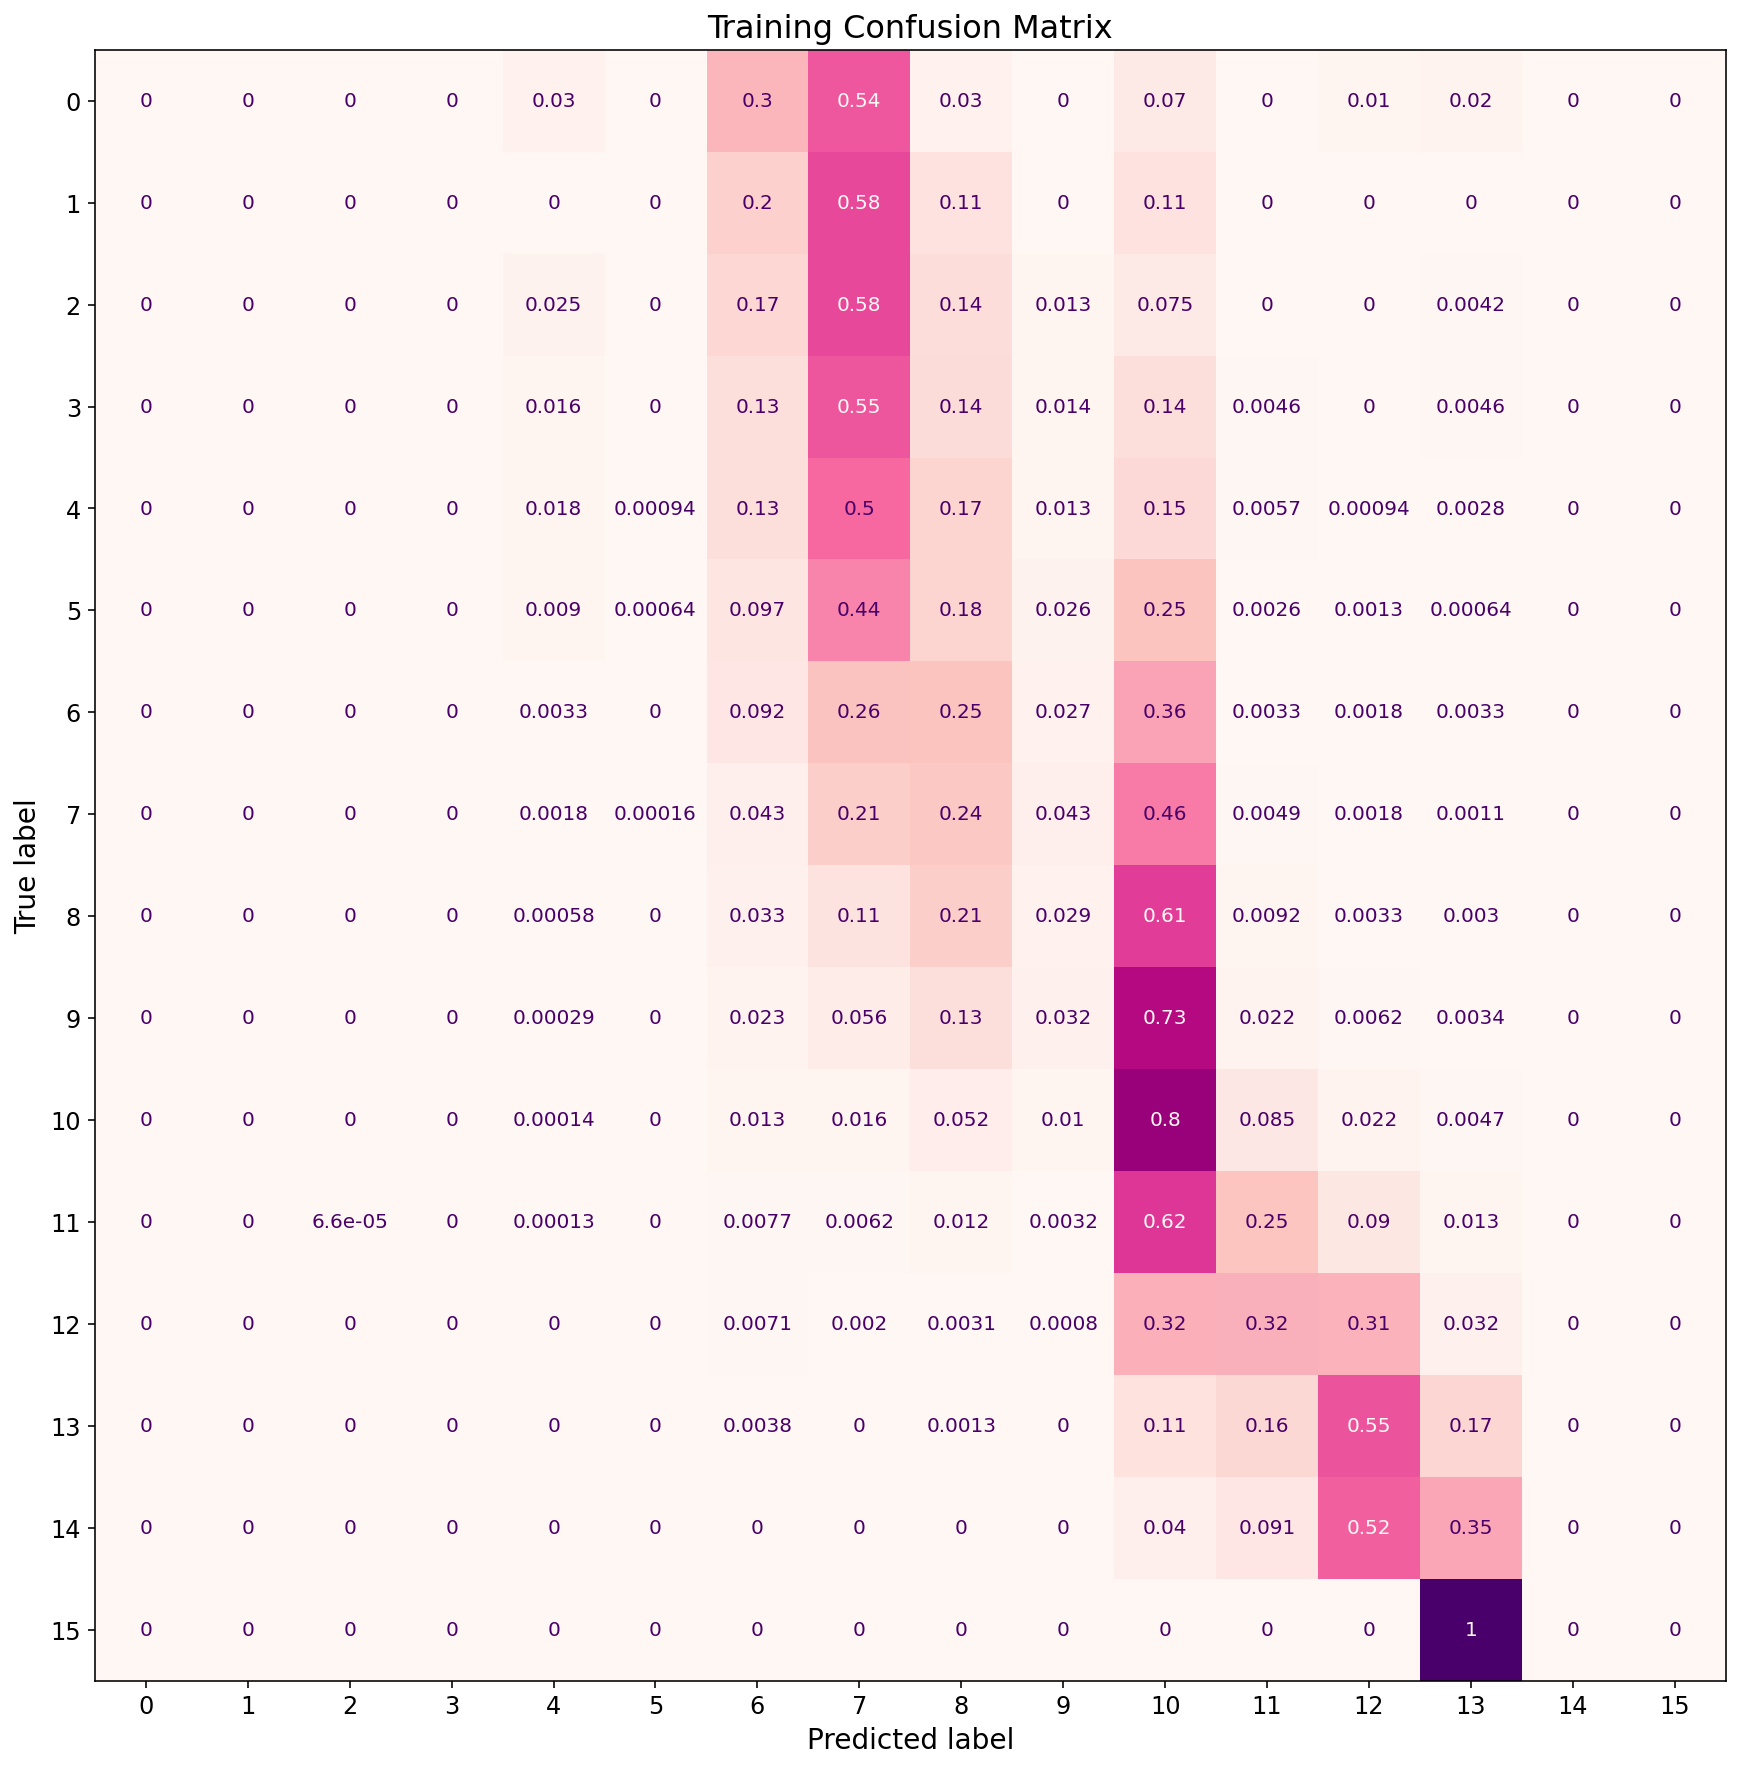

In [155]:
run_fasttext(new_train, new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='train');

In [107]:
#class distribution for reference
new_train['grade_reduced'].value_counts()

10    21084
11    15196
9     10489
12     8711
8      8559
7      6185
6      3364
13     2376
5      1556
4      1061
3       439
14      253
2       239
0       100
1        71
15        2
Name: grade_reduced, dtype: int64

In [188]:
#new null mae
mean_absolute_error(new_train['grade_reduced'], np.full_like(new_train['grade_reduced'], 10))

1.5204367195833595

The thing that stands out to me most here is the lack of predictions for 5.9, which is one of our majority classes. 5.10 gets the majority of predictions for 5.8-5.11, which seems very out of place given the number of rows available for those classes. The best possible explanation I can think is that those classes are similar enough that the model cannot distinguish between them. Time to look at the validation set as well.

Read 4M words
Number of words:  53112
Number of labels: 16
Progress: 100.0% words/sec/thread: 5726828 lr:  0.000000 avg.loss:  1.768290 ETA:   0h 0m 0s


Train Accuracy:		34.5%
Validation Accuracy:	32.4%
Test Accuracy:		32.4%
Test MAE:		1.16


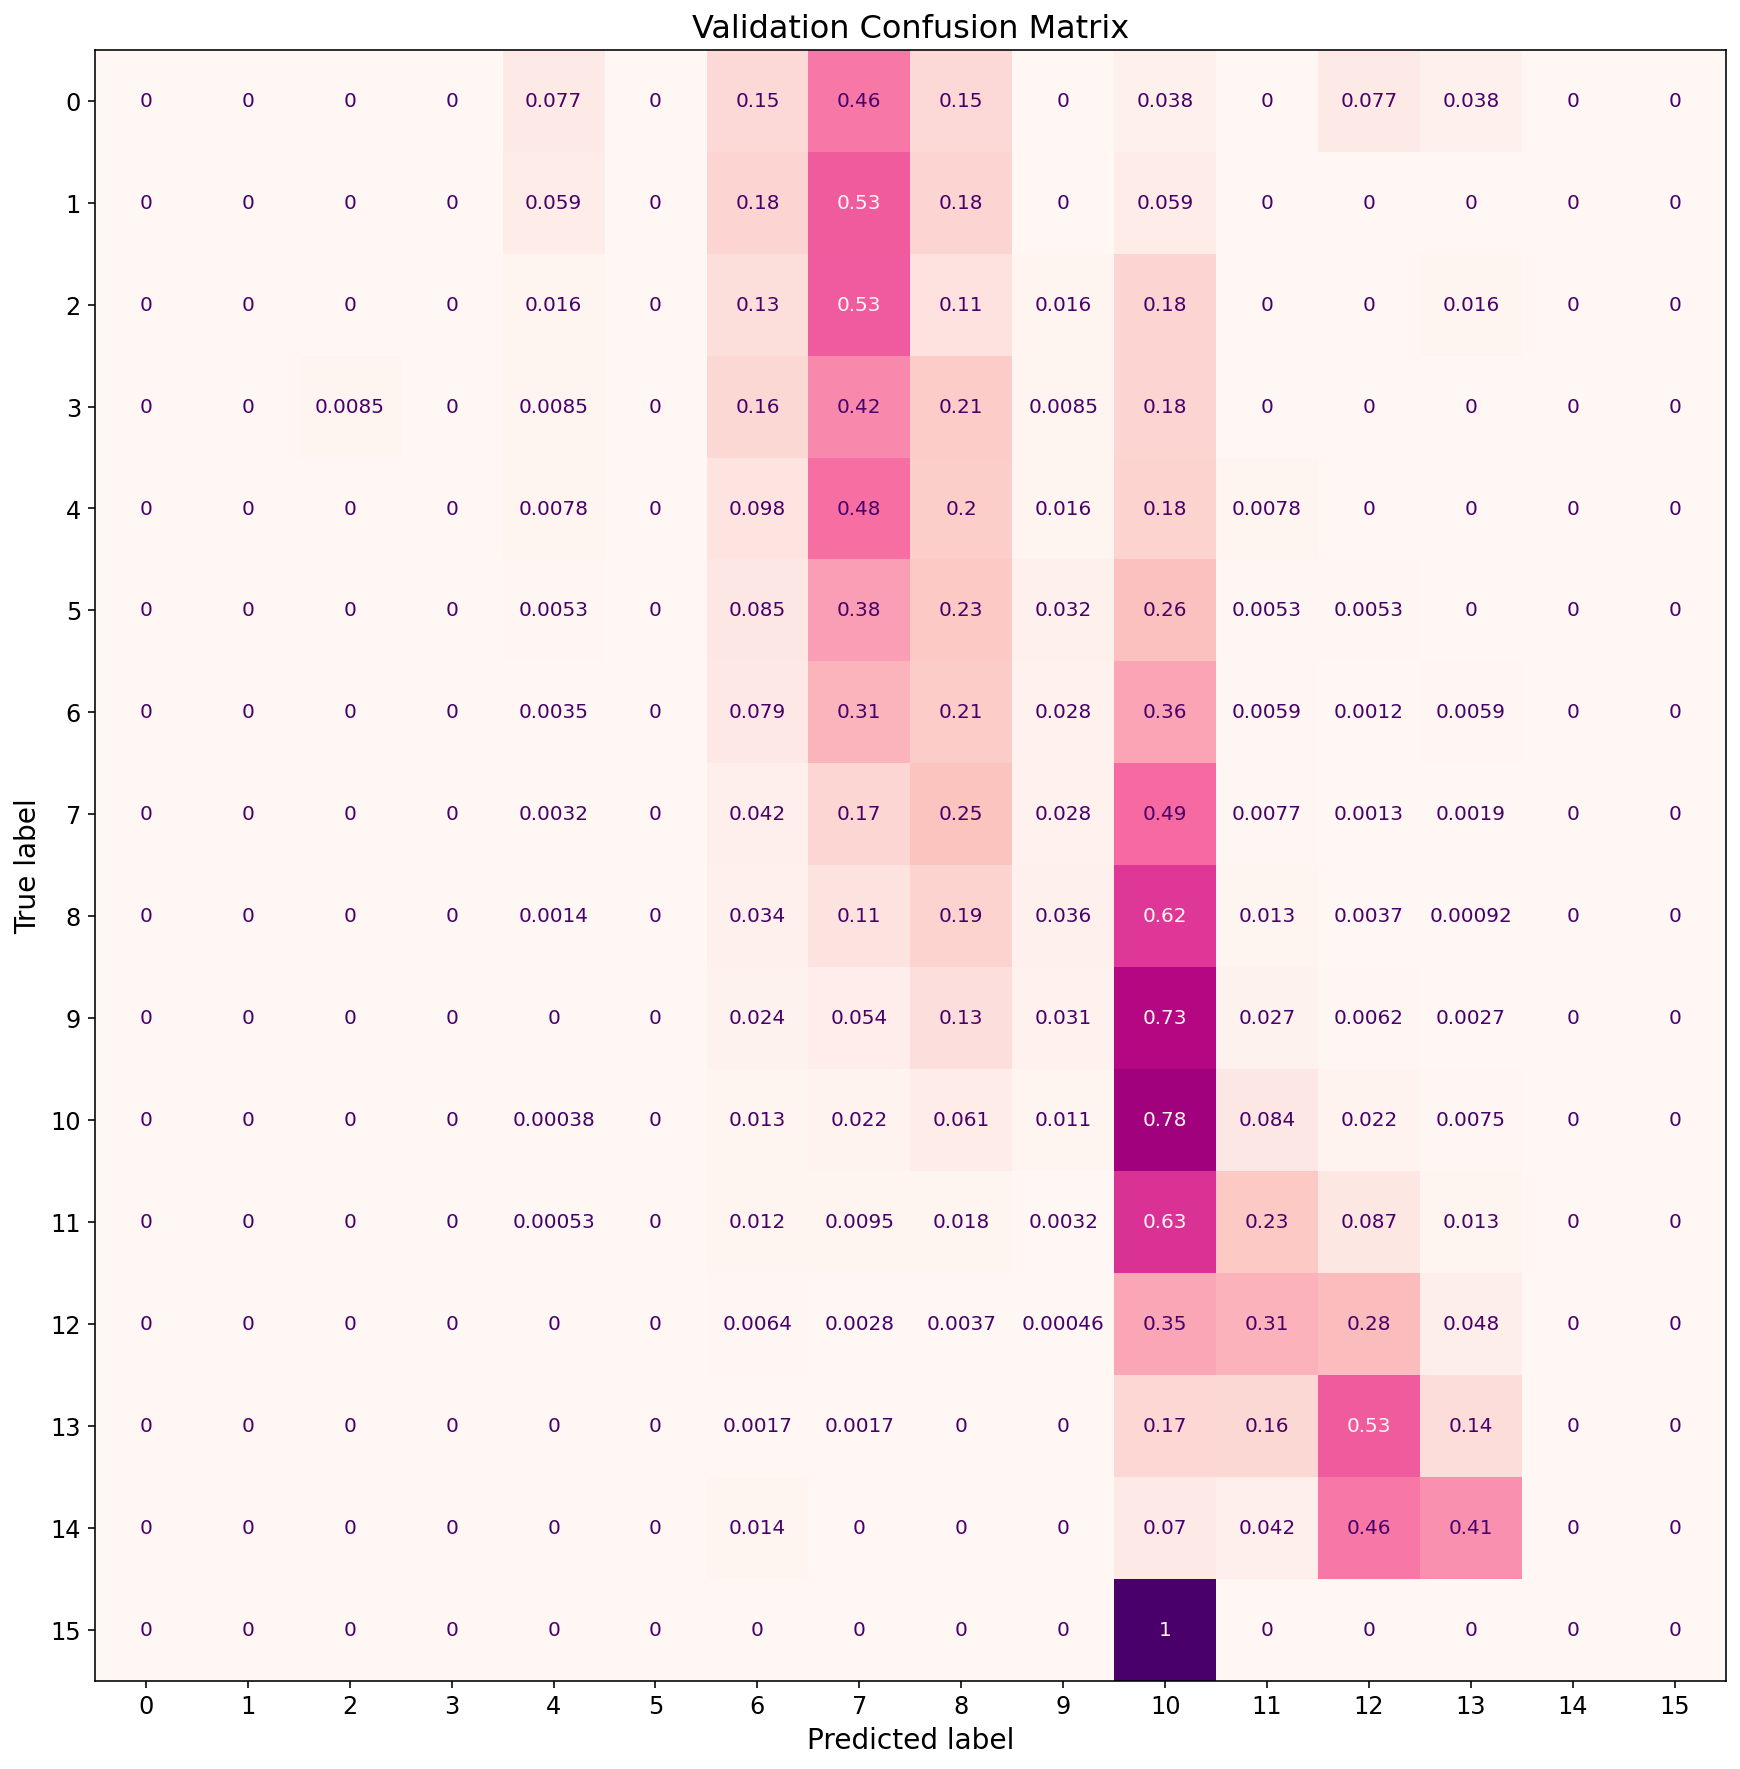

In [157]:
run_fasttext(new_train, new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='val');

The validation is basically identical, with the only major shift being that all 5.15 are predicted as 5.10 rather than as 5.13 like they were in the training.

## Over and Under Sampling using imbalanced-learn
The two most common approaches to class imbalance are over-sampling of the minority classes and under-sampling of the majority classes. Here we will use random over and under sampling from imbalanced learn, which allows us to easily resample non-numeric data. There are many more sophisticated methods of resampling, but unfortunately they require numeric data. [These](https://www.section.io/engineering-education/using-imbalanced-learn-to-handle-imbalanced-text-data/) [tutorials](http://michael-harmon.com/blog/NLP1.html) had some success using random over sampling with highly imbalanced datasets.

The way imbalanced learn handles resampling is to make the classes all the same size, unless specifed otherwise. Because the classes are so imbalanced, we're going to focus on bringing them to meet in the middle.

In [130]:
#class imbalances again
new_train['grade_reduced'].value_counts()

10    21084
11    15196
9     10489
12     8711
8      8559
7      6185
6      3364
13     2376
5      1556
4      1061
3       439
14      253
2       239
0       100
1        71
15        2
Name: grade_reduced, dtype: int64

First we'll try a simple doubling of the minority classes, leaving the majority classes the same.

Read 6M words
Number of words:  53112
Number of labels: 16
Progress: 100.0% words/sec/thread: 5751882 lr:  0.000000 avg.loss:  1.418700 ETA:   0h 0m 0s


Train Accuracy:		27.4%
Validation Accuracy:	19.5%
Test Accuracy:		20.0%
Test MAE:		1.53


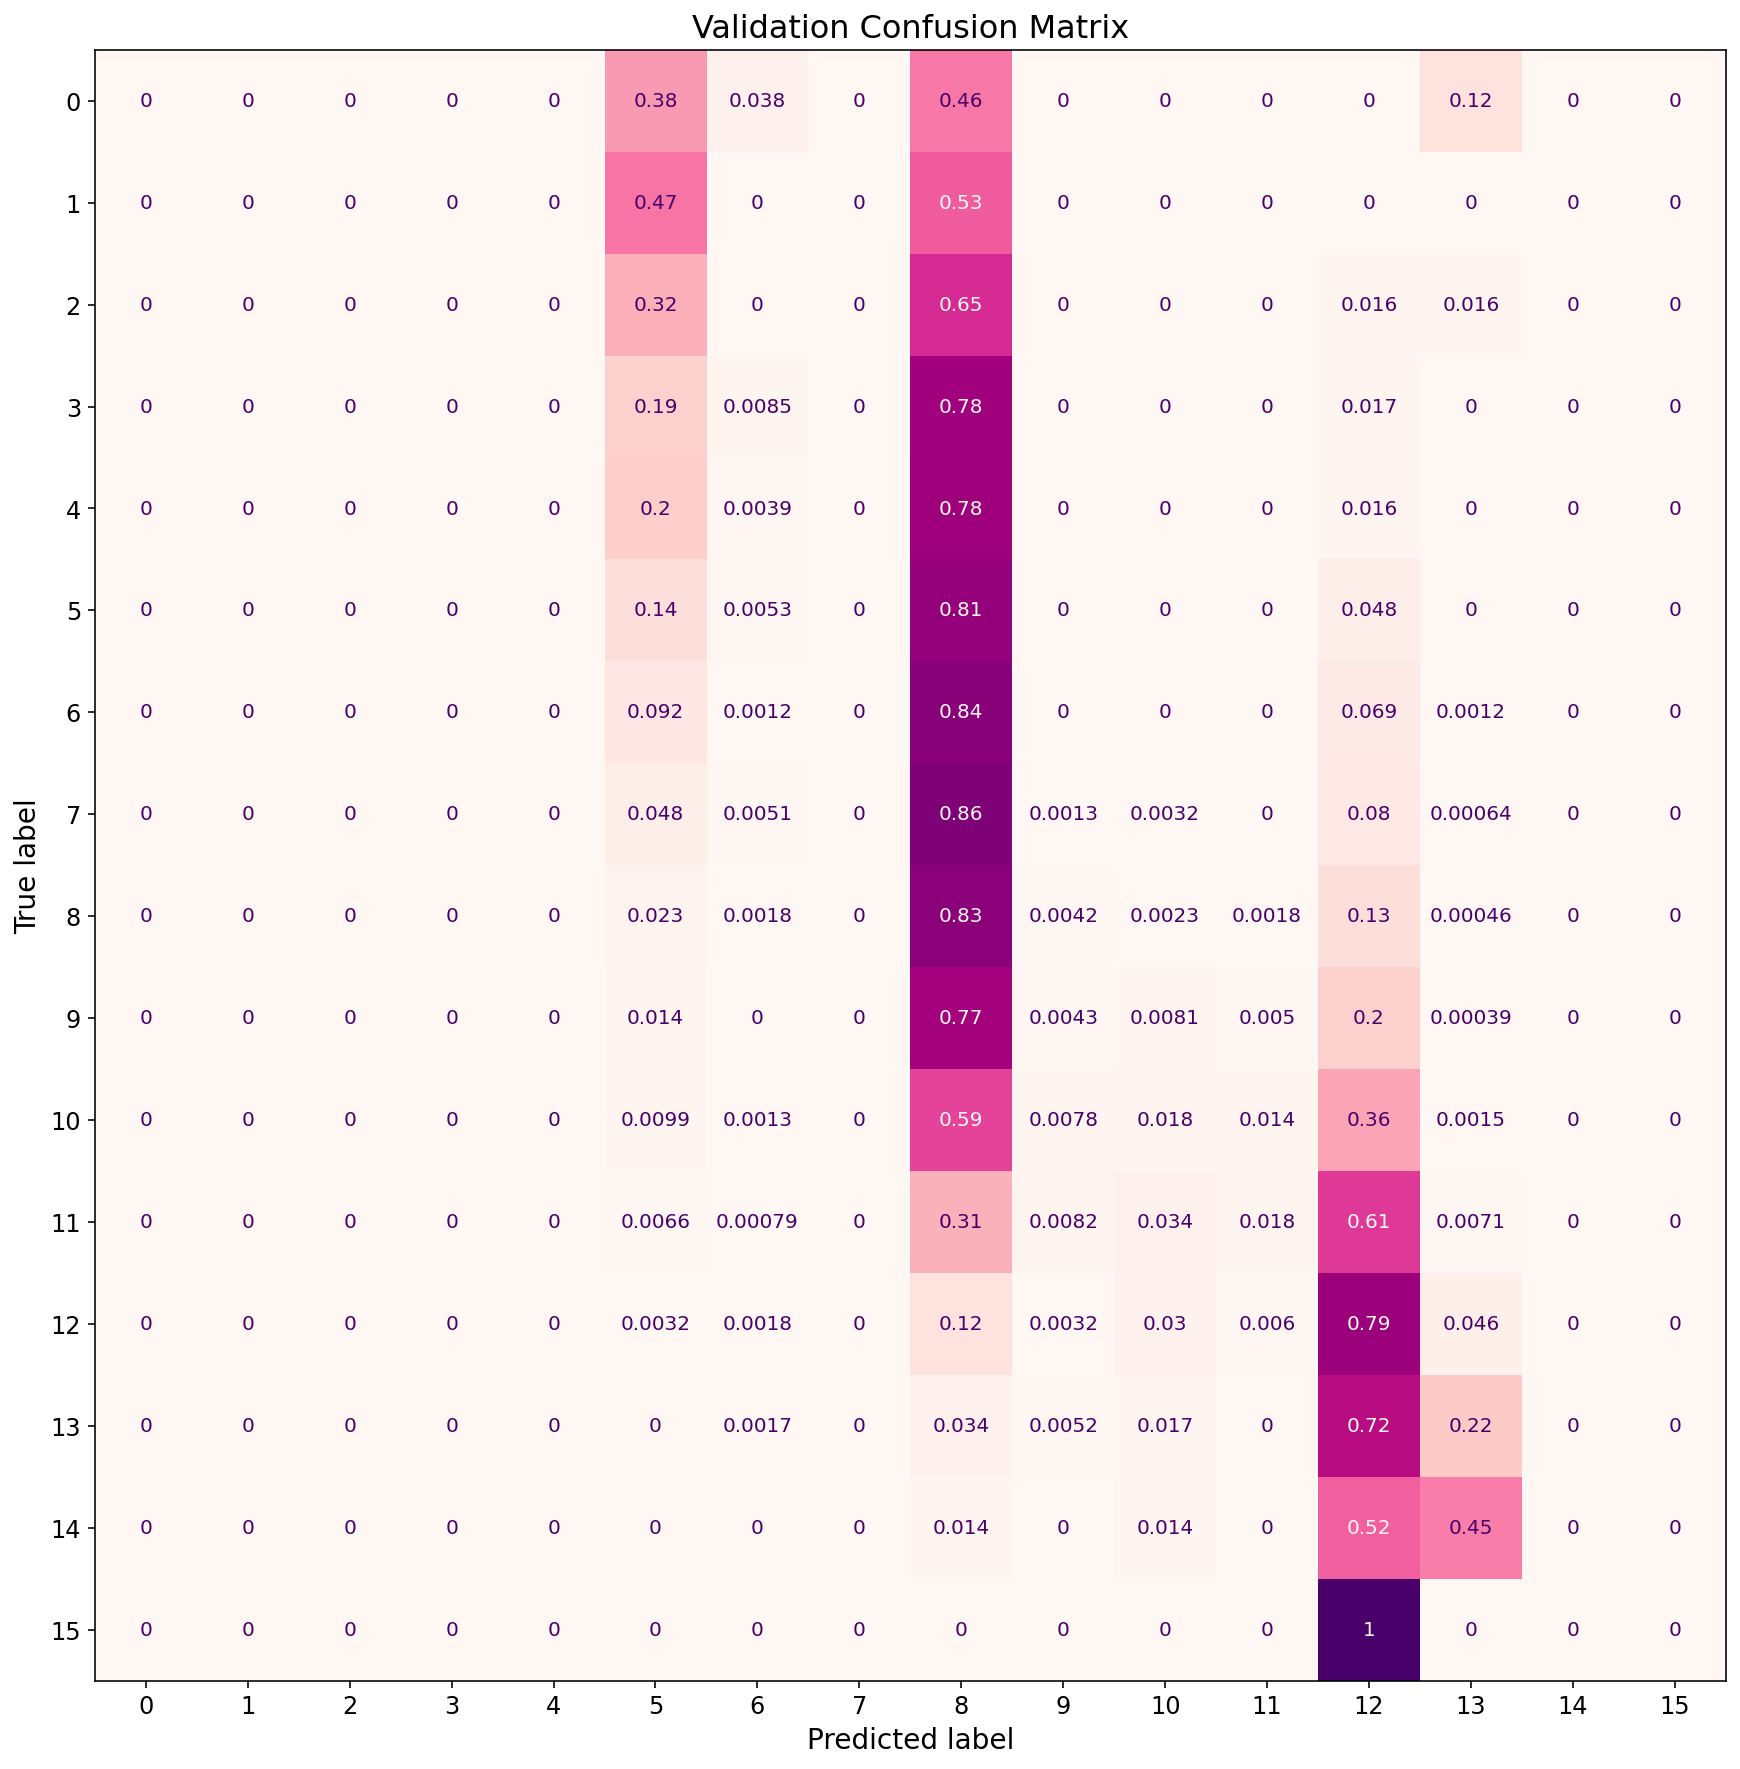

In [158]:
sample_dict = {k: v*2 for k, v in new_train['grade_reduced'].value_counts().items() if k not in (10, 11, 9)}

ros = RandomOverSampler(random_state=42, sampling_strategy=sample_dict)
balanced_X_train, balanced_y_train = ros.fit_resample(new_train[['lemmatized_text_combined']], new_train['grade_reduced'], )

run_fasttext(pd.concat([balanced_X_train, balanced_y_train], axis=1), new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='val');

Undersampling just strengthened stratification in the predictions, but the stratification shifted from 7, 10, and 12 to 5, 8, and 12. Next we'll try random under sampling by just halving the majority class.

Read 3M words
Number of words:  49985
Number of labels: 16
Progress: 100.0% words/sec/thread: 5660744 lr:  0.000000 avg.loss:  0.366174 ETA:   0h 0m 0s


Train Accuracy:		13.0%
Validation Accuracy:	11.2%
Test Accuracy:		11.5%
Test MAE:		2.53


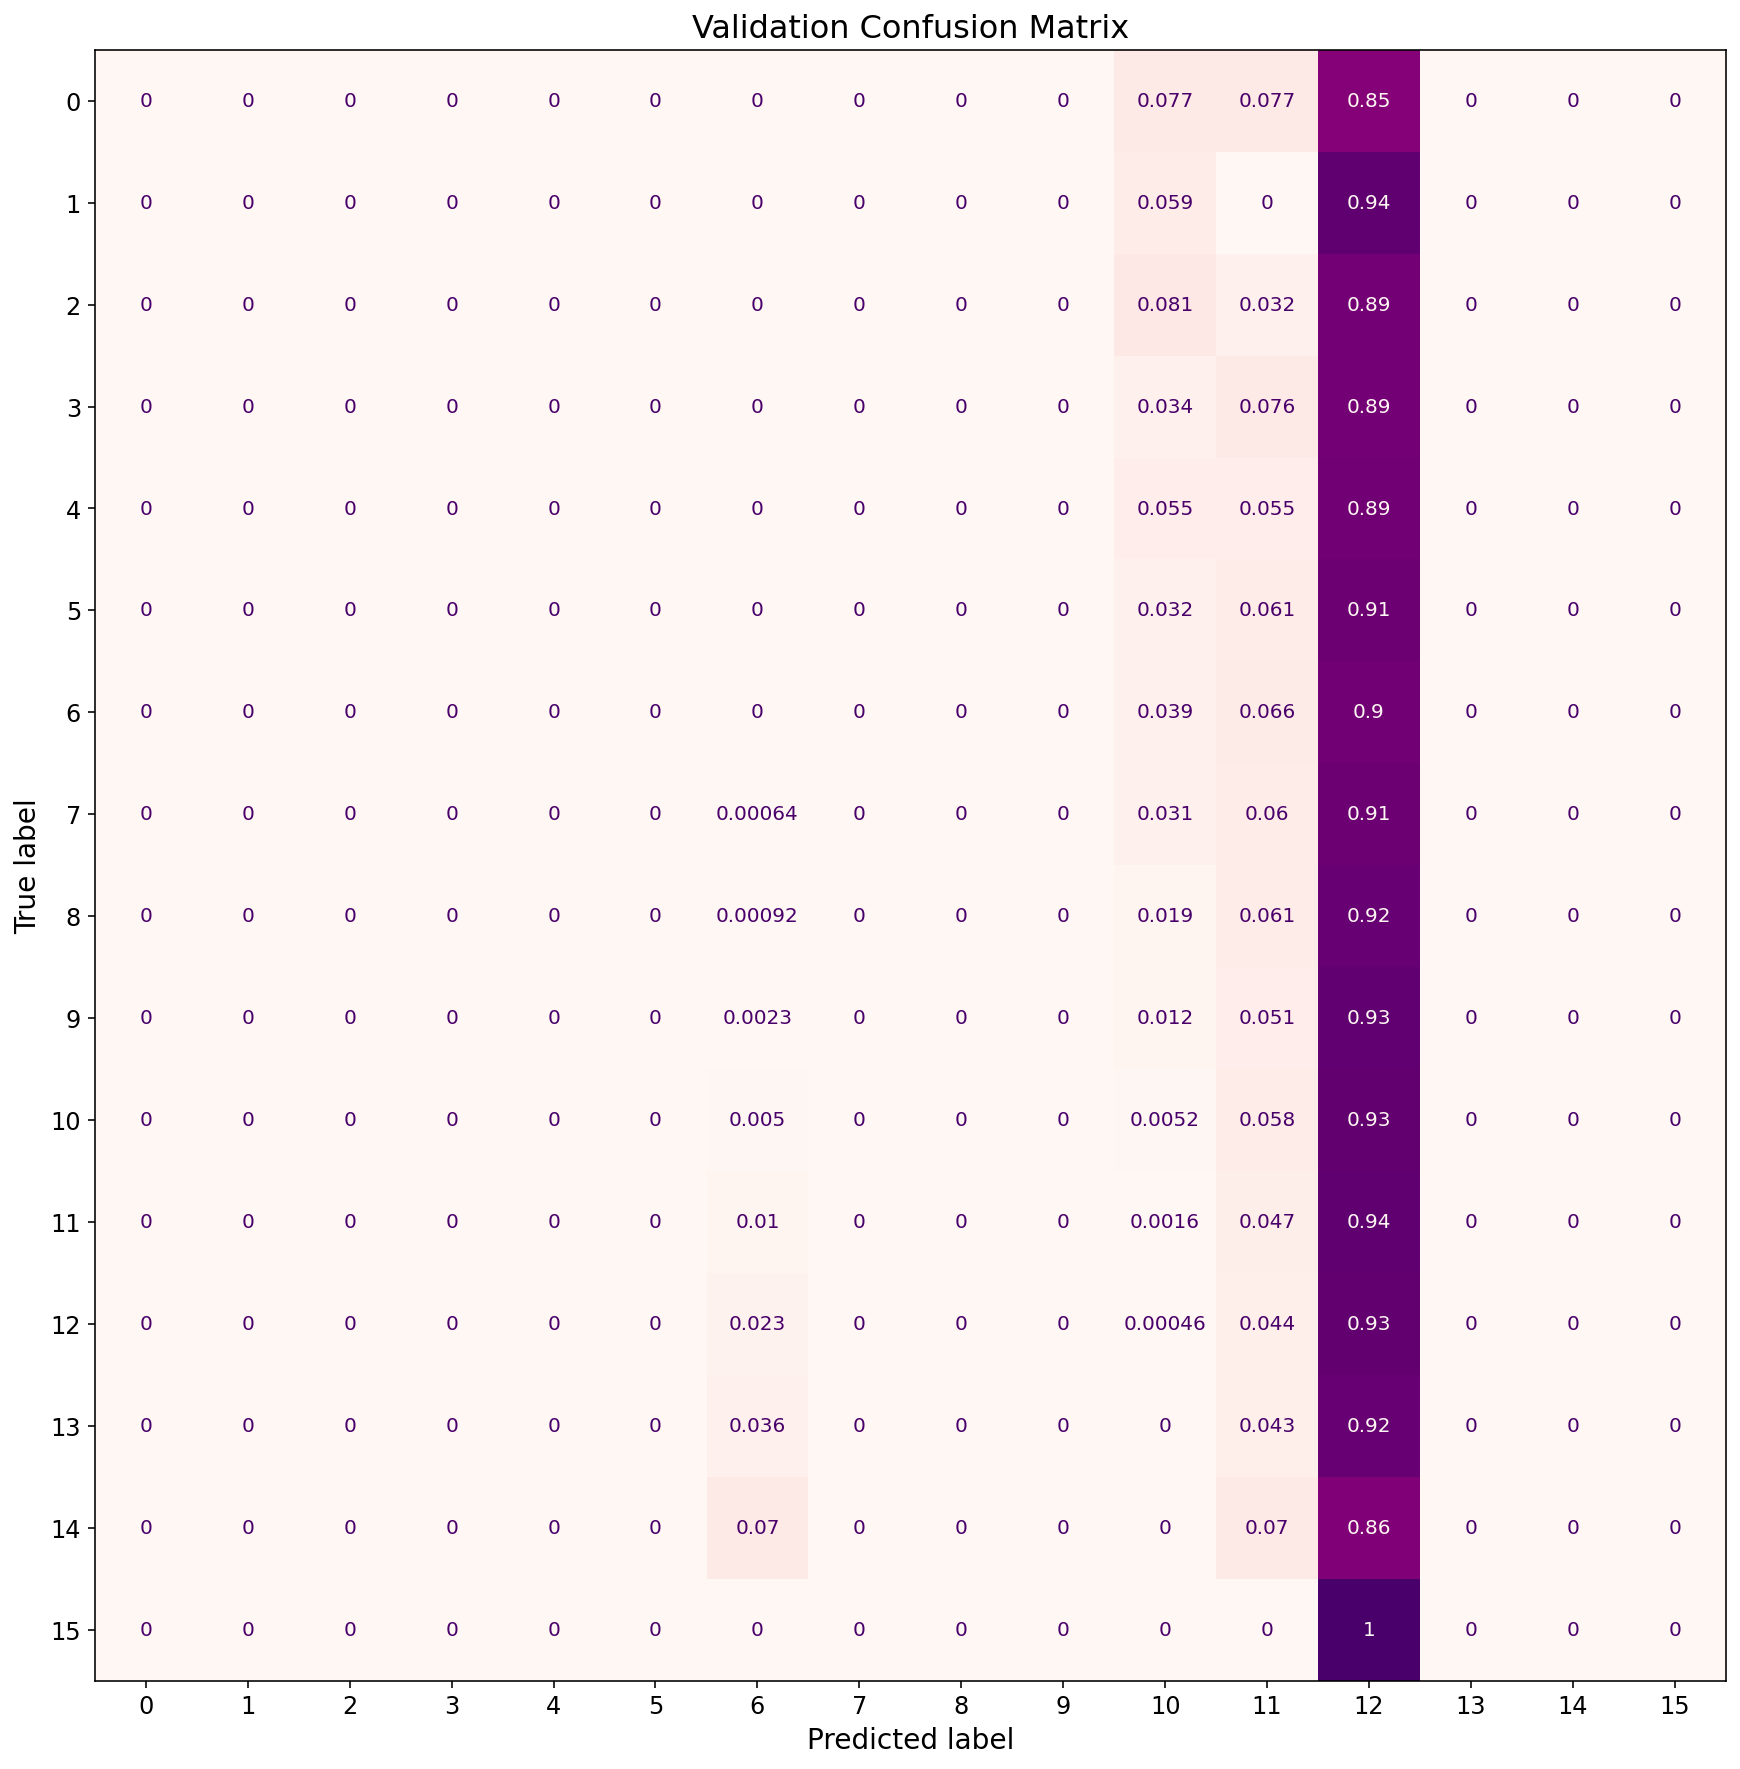

In [159]:
sample_dict = {k: v // 2 for k, v in new_train['grade_reduced'].value_counts().items() if k == 10}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_dict)
balanced_X_train, balanced_y_train = rus.fit_resample(new_train[['lemmatized_text_combined']], new_train['grade_reduced'], )

run_fasttext(pd.concat([balanced_X_train, balanced_y_train], axis=1), new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='val');

In [147]:
balanced_y_train.value_counts()

11    15196
10    10542
9     10489
12     8711
8      8559
7      6185
6      3364
13     2376
5      1556
4      1061
3       439
14      253
2       239
0       100
1        71
15        2
Name: grade_reduced, dtype: int64

Although the model only predicts 12, 12 isn't even the majority class after undersampling. I'm going to try auto-tuning this version, just because these results are so weird.

Progress: 100.0% Trials:    8 Best score:  0.252454 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  49985
Number of labels: 16
Progress: 100.0% words/sec/thread: 1235053 lr:  0.000000 avg.loss:  1.843850 ETA:   0h 0m 0s


Train Accuracy:		27.2%
Validation Accuracy:	25.9%
Test Accuracy:		26.3%
Test MAE:		1.4


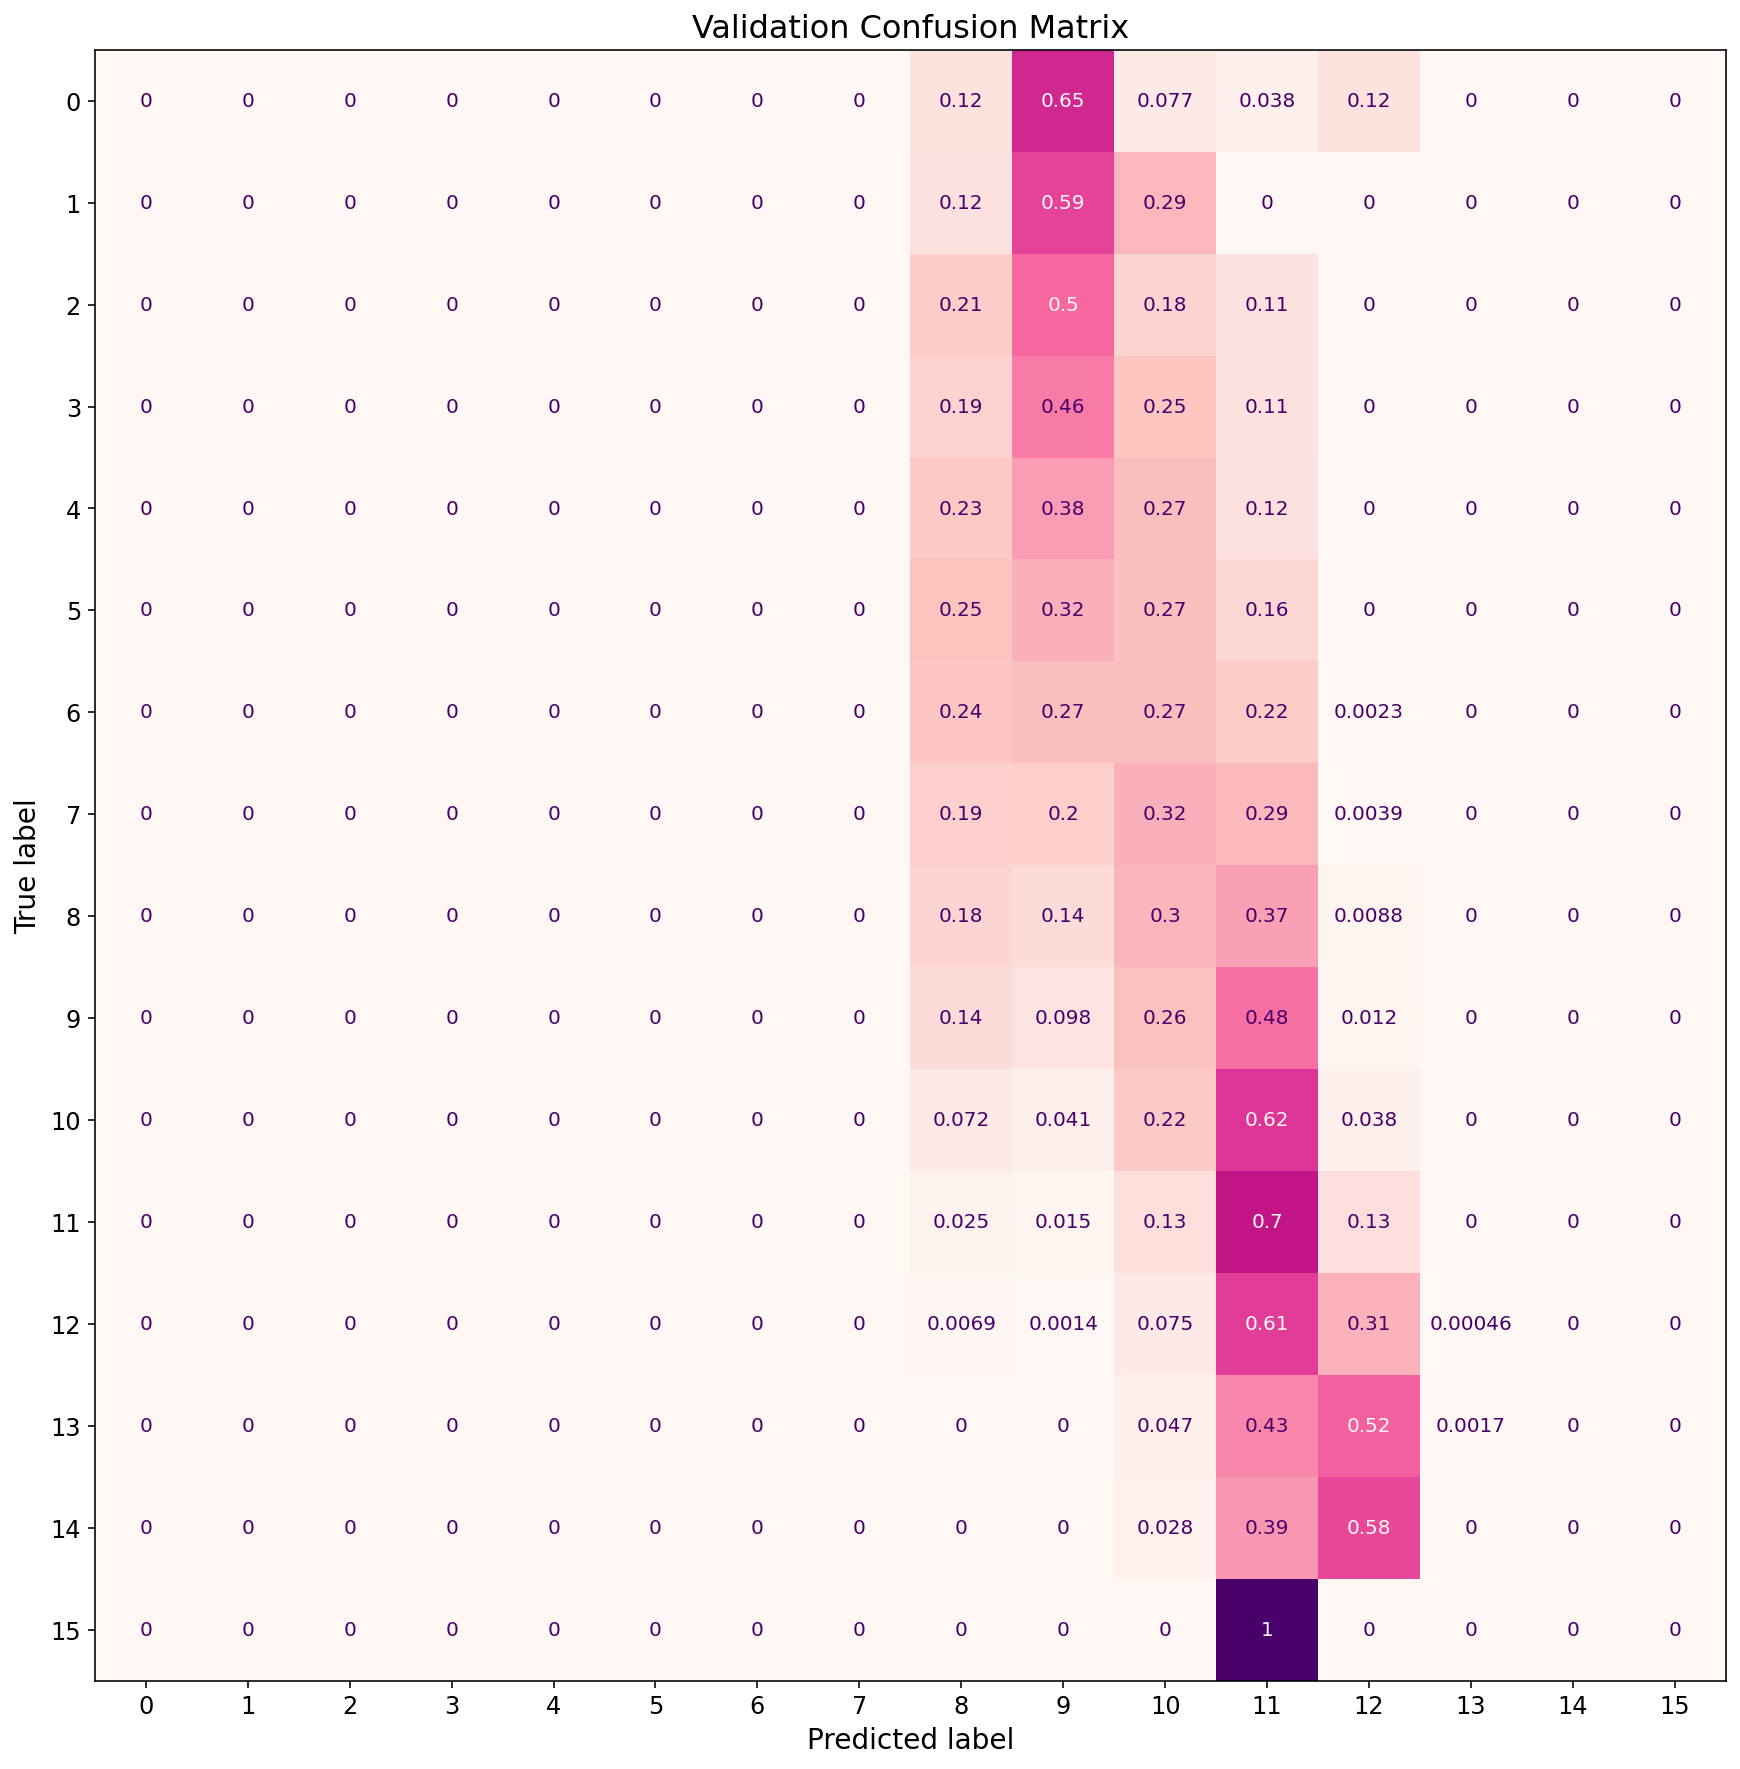

In [160]:
run_fasttext(pd.concat([balanced_X_train, balanced_y_train], axis=1), new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='val', autotune=True);

With tuning the undersampled model move predictions to 9 and 11, despite there still being plenty of values in the other classes. One final option is to combine both under and over sampling.

Read 5M words
Number of words:  50272
Number of labels: 16
Progress: 100.0% words/sec/thread: 5114835 lr:  0.000000 avg.loss:  0.350564 ETA:   0h 0m 0s


Train Accuracy:		8.5%
Validation Accuracy:	10.0%
Test Accuracy:		10.2%
Test MAE:		2.67


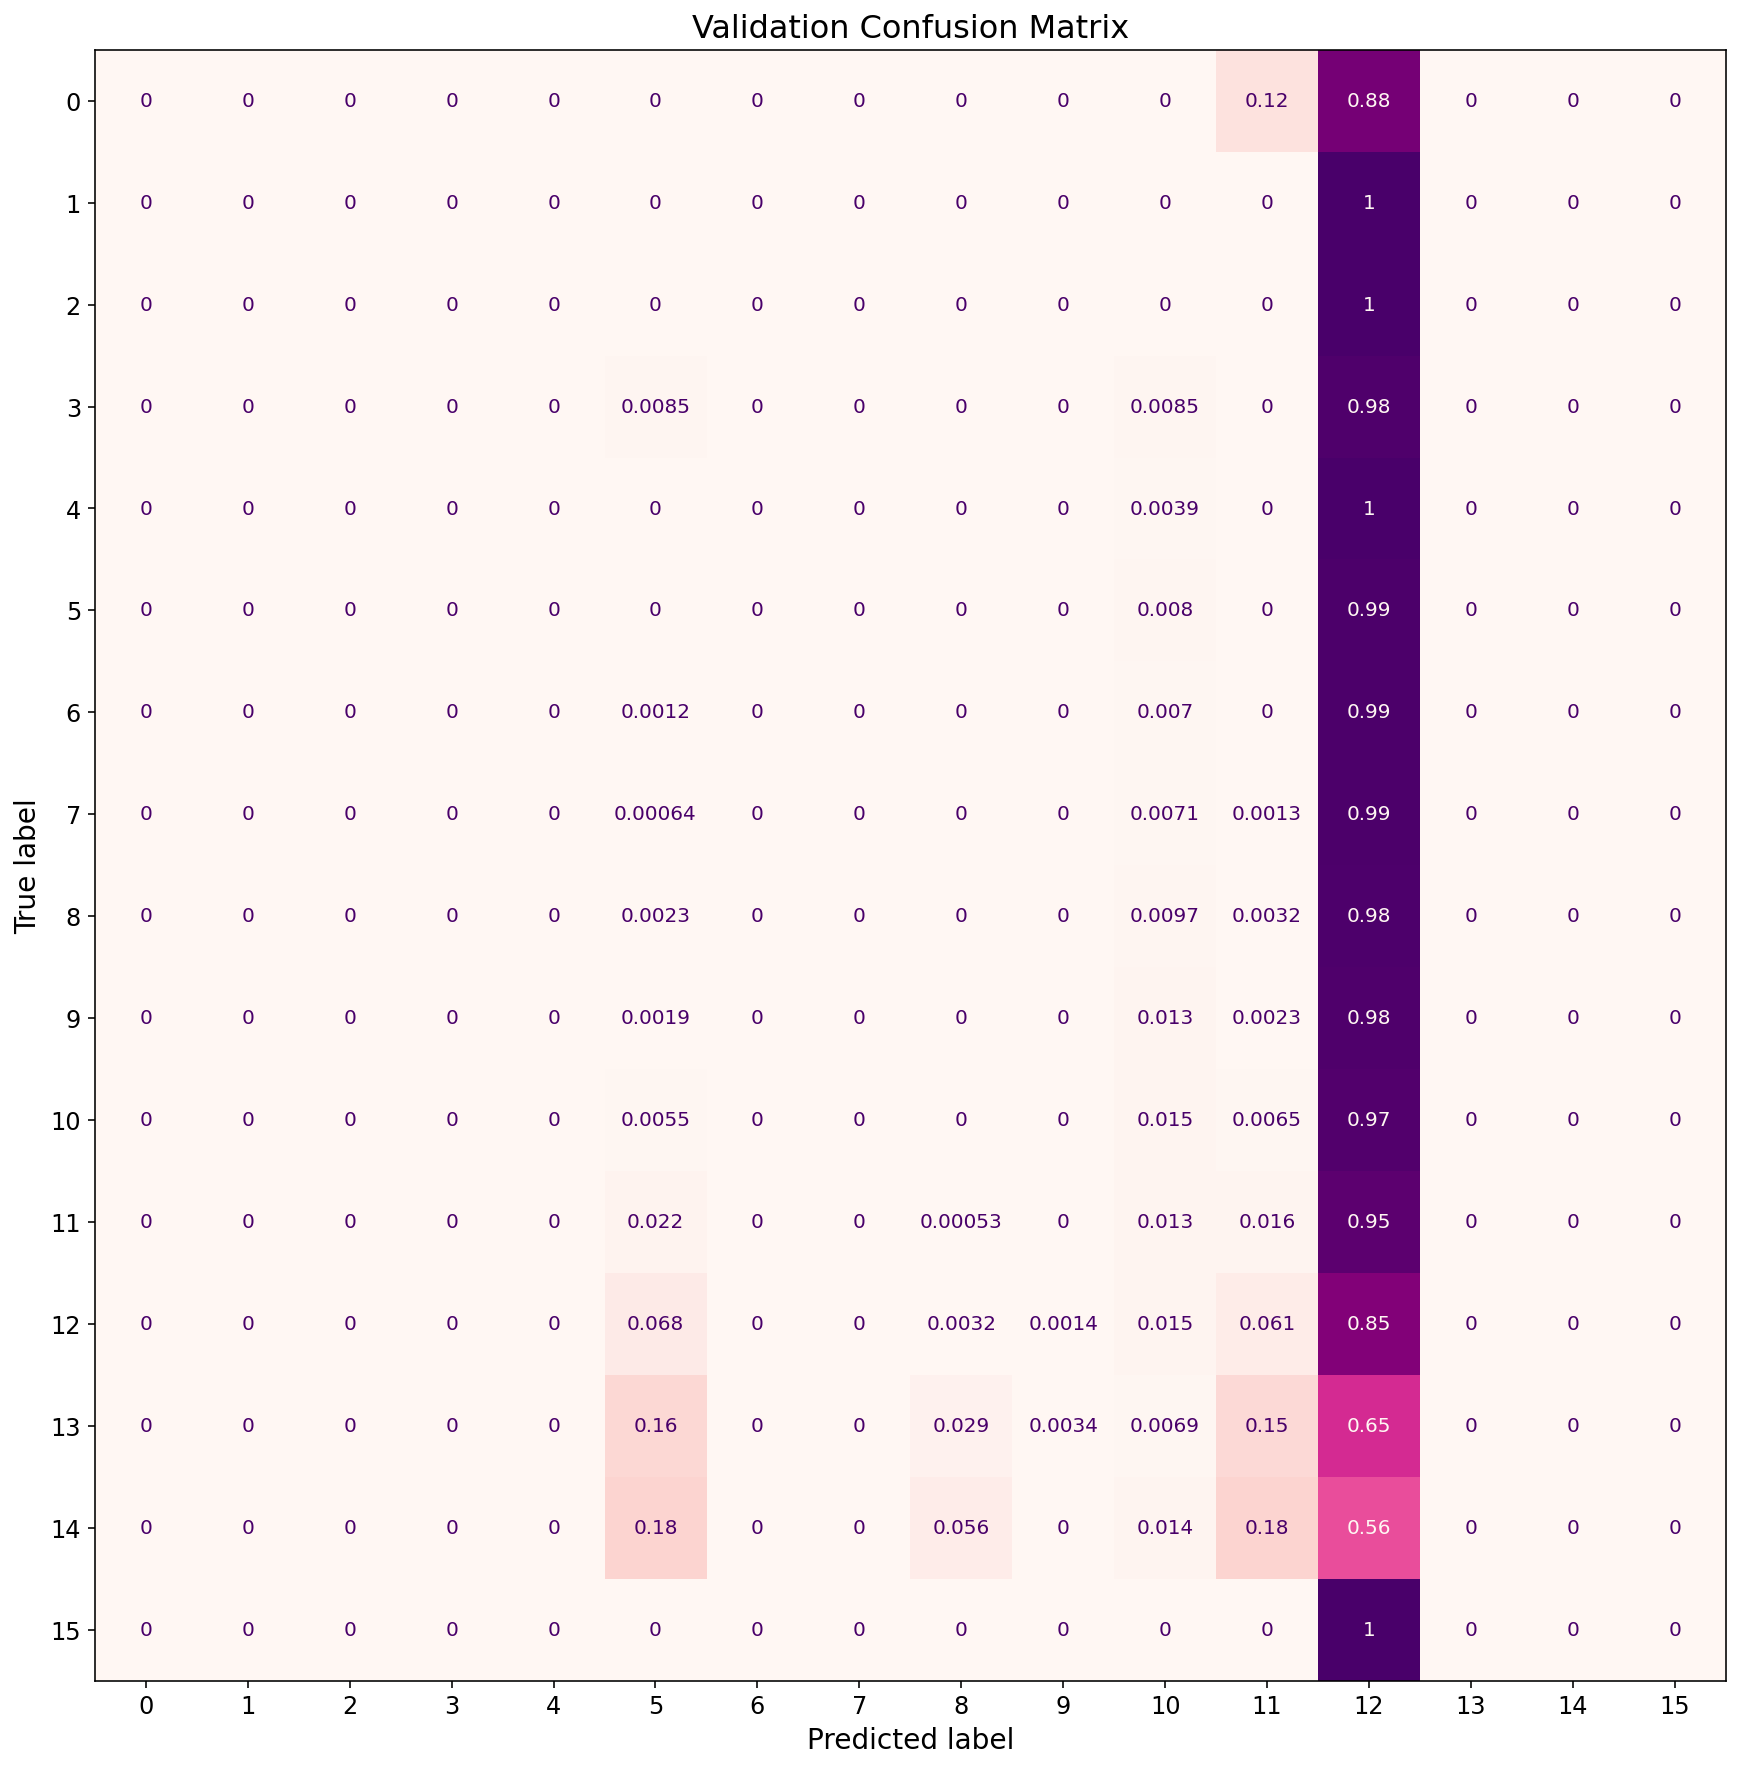

In [164]:
#oversample the minority classes
ros_sample_dict = {k: int(v*2) for k, v in new_train['grade_reduced'].value_counts().items() if k not in (10, 11, 9, 12)}
ros = RandomOverSampler(random_state=42, sampling_strategy=ros_sample_dict)
balanced_X_train, balanced_y_train = ros.fit_resample(new_train[['lemmatized_text_combined']], new_train['grade_reduced'])

#undersample the 2 majority classes
rus_sample_dict = {k: int(v*.75) for k, v in new_train['grade_reduced'].value_counts().items() if k in (10, 11)}
rus = RandomUnderSampler(random_state=42, sampling_strategy=rus_sample_dict)
balanced_X_train, balanced_y_train = rus.fit_resample(balanced_X_train, balanced_y_train)

run_fasttext(pd.concat([balanced_X_train, balanced_y_train], axis=1), new_val, new_test, 'grade_reduced', ['lemmatized_text_combined'], confusion_matrix='val');

With the worst predictions, we've seen so far, my final conclusion is that random over and under sampling is not helpful with this dataset. Further discussion of resampling methods will be below in the conclusions and future work.

## Reduction of Target Classes
At this point, it is clear that a useful model on all of the classes is not feasible. Therefore, class reduction is the next logical step. There are a few ways we can reduce the classes:
1. Drop all classes on the tails of the distribution, keeping the middle core and predicting for class as above
2. Group the classes and predict the group

First, we'll drop the classes at the edges of the distribution. This leaves the core classes of 8-12, or 9-11 if we only want classes with at least 10k training rows. 

### Classification of 8-12 Only

In [171]:
#new class imbalances
new_train[(new_train['grade_reduced'] >= 8) & (new_train['grade_reduced'] < 13)]['grade_reduced'].value_counts(normalize=True)              

10    0.329237
11    0.237293
9     0.163791
12    0.136026
8     0.133653
Name: grade_reduced, dtype: float64

In [189]:
#new null MAE
mean_absolute_error(new_train[(new_train['grade_reduced'] >= 8) & (new_train['grade_reduced'] < 13)]['grade_reduced'], 
                    np.full_like(new_train[(new_train['grade_reduced'] >= 8) & (new_train['grade_reduced'] < 13)]['grade_reduced'], 10))

0.9404425428254657

With this subset of classes, 32.9% becomes the new null accuracy. Because these are our final few iterations, I'm going to autotune them right off the bat.

Progress: 100.0% Trials:   18 Best score:  0.390533 ETA:   0h 0m 0s
Training again with best arguments
Read 3M words
Number of words:  47579
Number of labels: 5
Progress: 100.0% words/sec/thread:  215500 lr:  0.000000 avg.loss:  1.338609 ETA:   0h 0m 0s


Train Accuracy:		42.7%
Validation Accuracy:	38.9%
Test Accuracy:		38.6%
Test MAE:		0.82


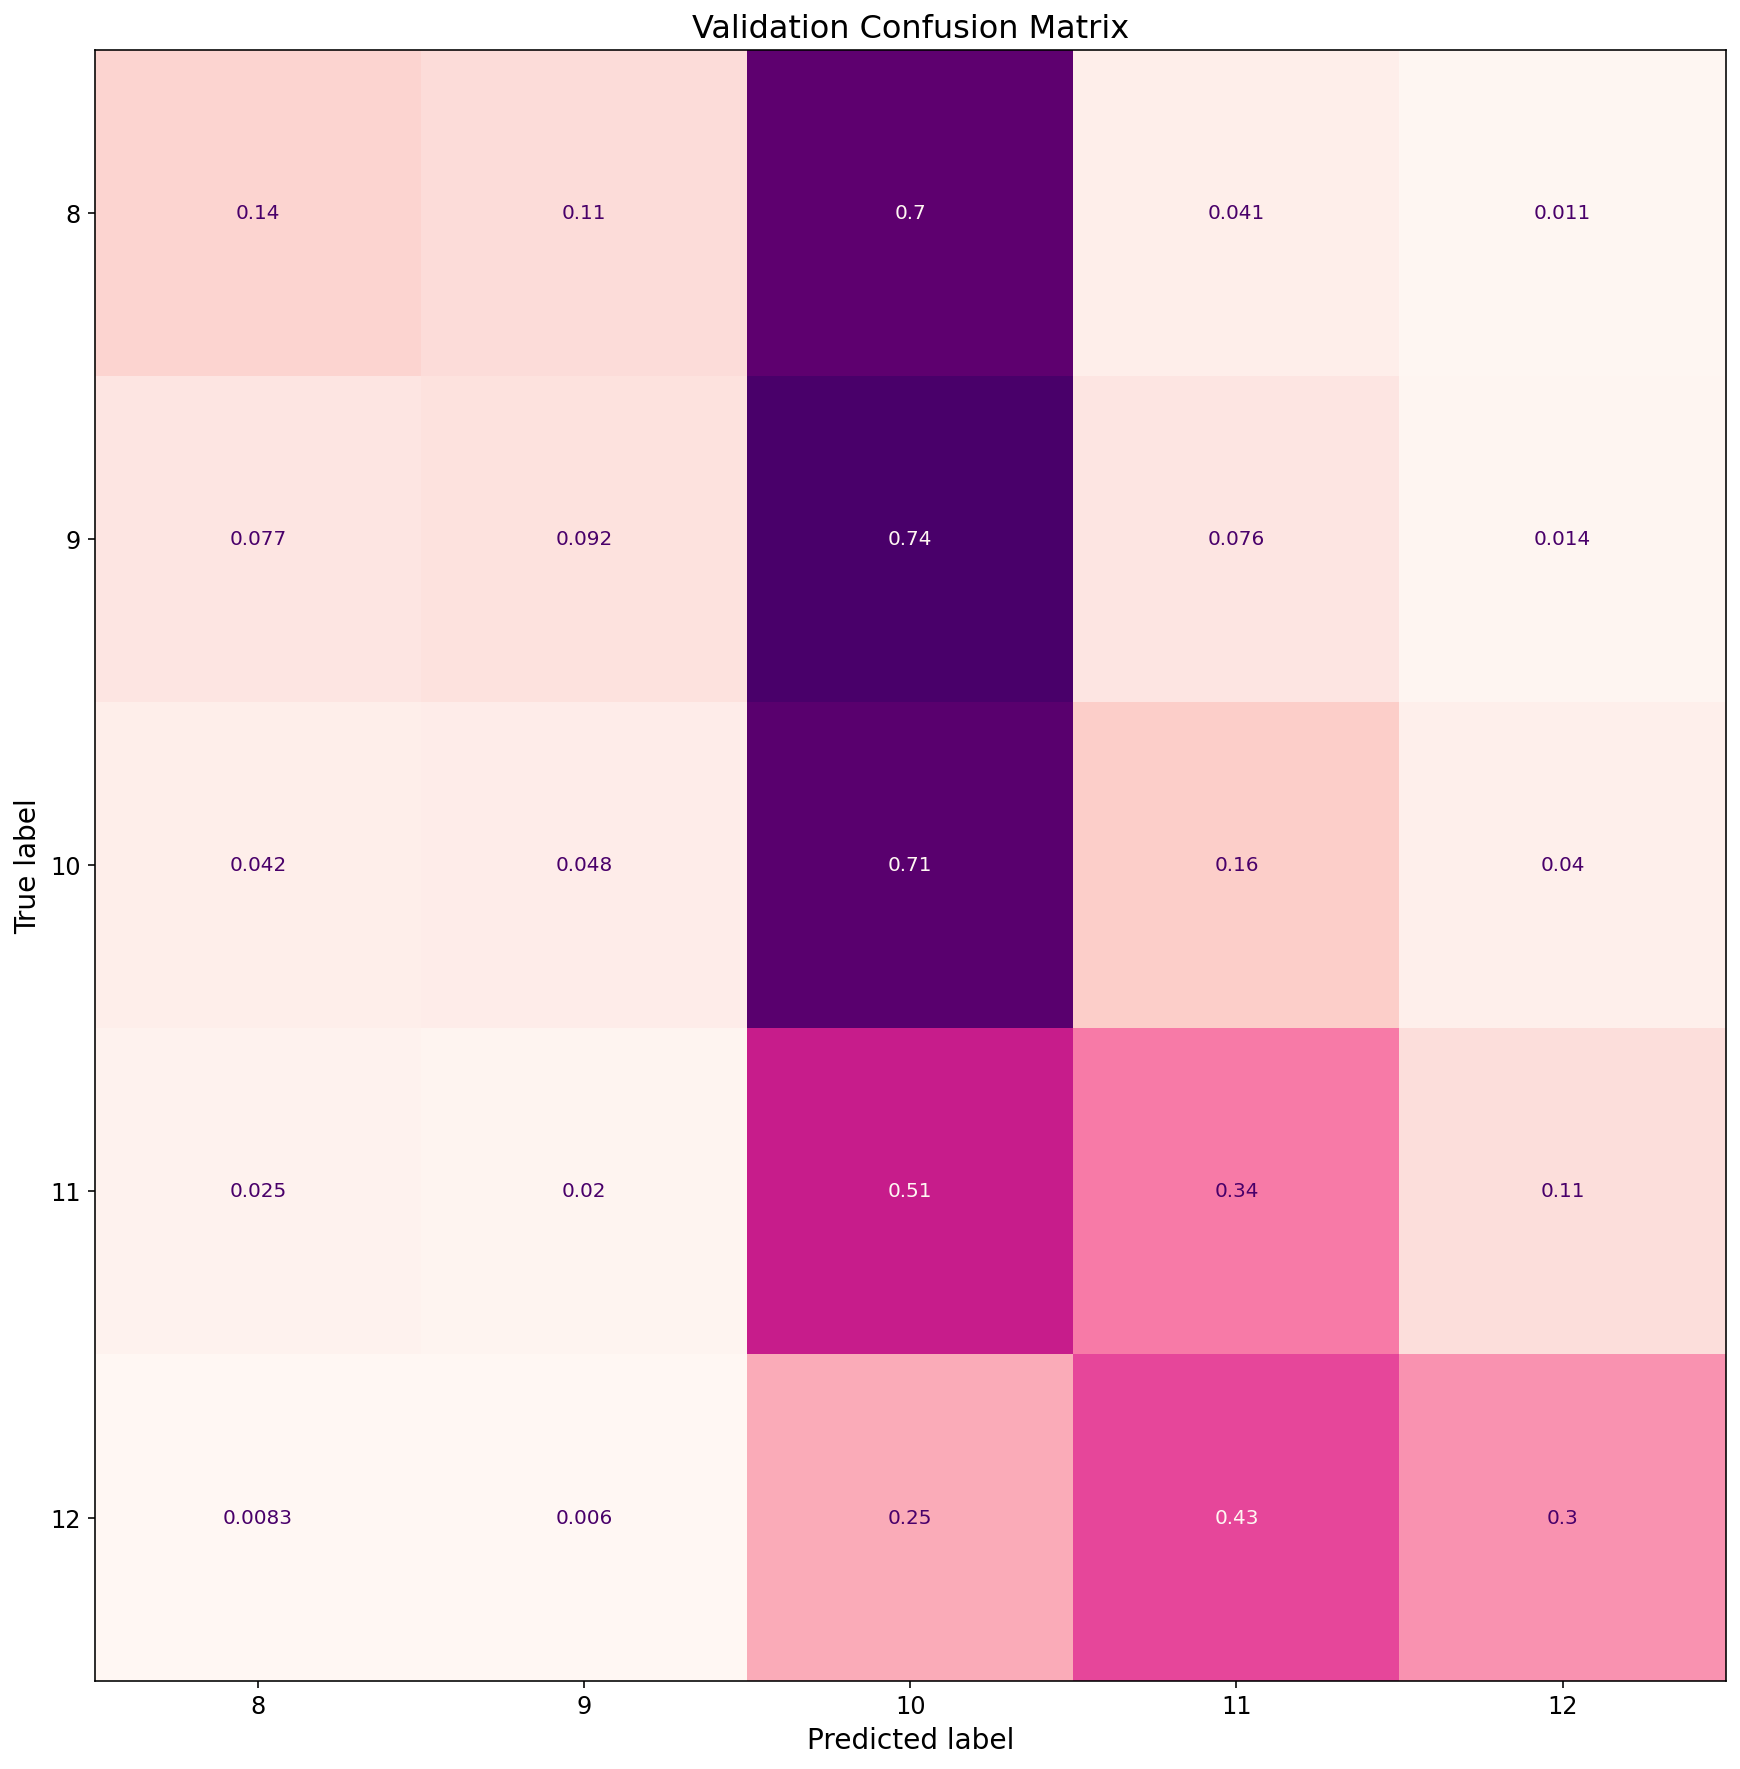

In [172]:
run_fasttext(new_train.loc[new_train[(new_train['grade_reduced'] >= 8) & (new_train['grade_reduced'] < 13)].index, :],
             new_val.loc[new_val[(new_val['grade_reduced'] >= 8) & (new_val['grade_reduced'] < 13)].index, :],
             new_test.loc[new_test[(new_test['grade_reduced'] >= 8) & (new_test['grade_reduced'] < 13)].index, :],
             'grade_reduced', 
             ['lemmatized_text_combined'],
             confusion_matrix = 'val', 
             autotune=True);

Again we see the class imbalance pull all the predictions towards 5.10. This model has similar accuracy to the models we saw with all 16 classes above, as well as a similar reduction in MAE.

### Classification of 9-11 Only
These are our largest classes, so theoretically slimming a model to just these may do well. However, from our eda these also had high similarity, so may prove to be the most challenging classes.

In [174]:
#new class imbalances
new_train.loc[new_train[(new_train['grade_reduced'] >= 9) & (new_train['grade_reduced'] < 12)].index, 'grade_reduced'].value_counts(normalize=True)

10    0.450811
11    0.324916
9     0.224272
Name: grade_reduced, dtype: float64

In [190]:
#new null MAE
mean_absolute_error(new_train.loc[new_train[(new_train['grade_reduced'] >= 9) & (new_train['grade_reduced'] < 12)].index, 'grade_reduced'],
                    np.full_like(new_train.loc[new_train[(new_train['grade_reduced'] >= 9) & (new_train['grade_reduced'] < 12)].index, 'grade_reduced'], 10))

0.5491885650751567

Progress: 100.0% Trials:   22 Best score:  0.515843 ETA:   0h 0m 0s
Training again with best arguments
Read 2M words
Number of words:  40362
Number of labels: 3
Progress: 100.0% words/sec/thread: 1807111 lr:  0.000000 avg.loss:  0.969721 ETA:   0h 0m 0s


Train Accuracy:		52.9%
Validation Accuracy:	51.4%
Test Accuracy:		50.1%
Test MAE:		0.53


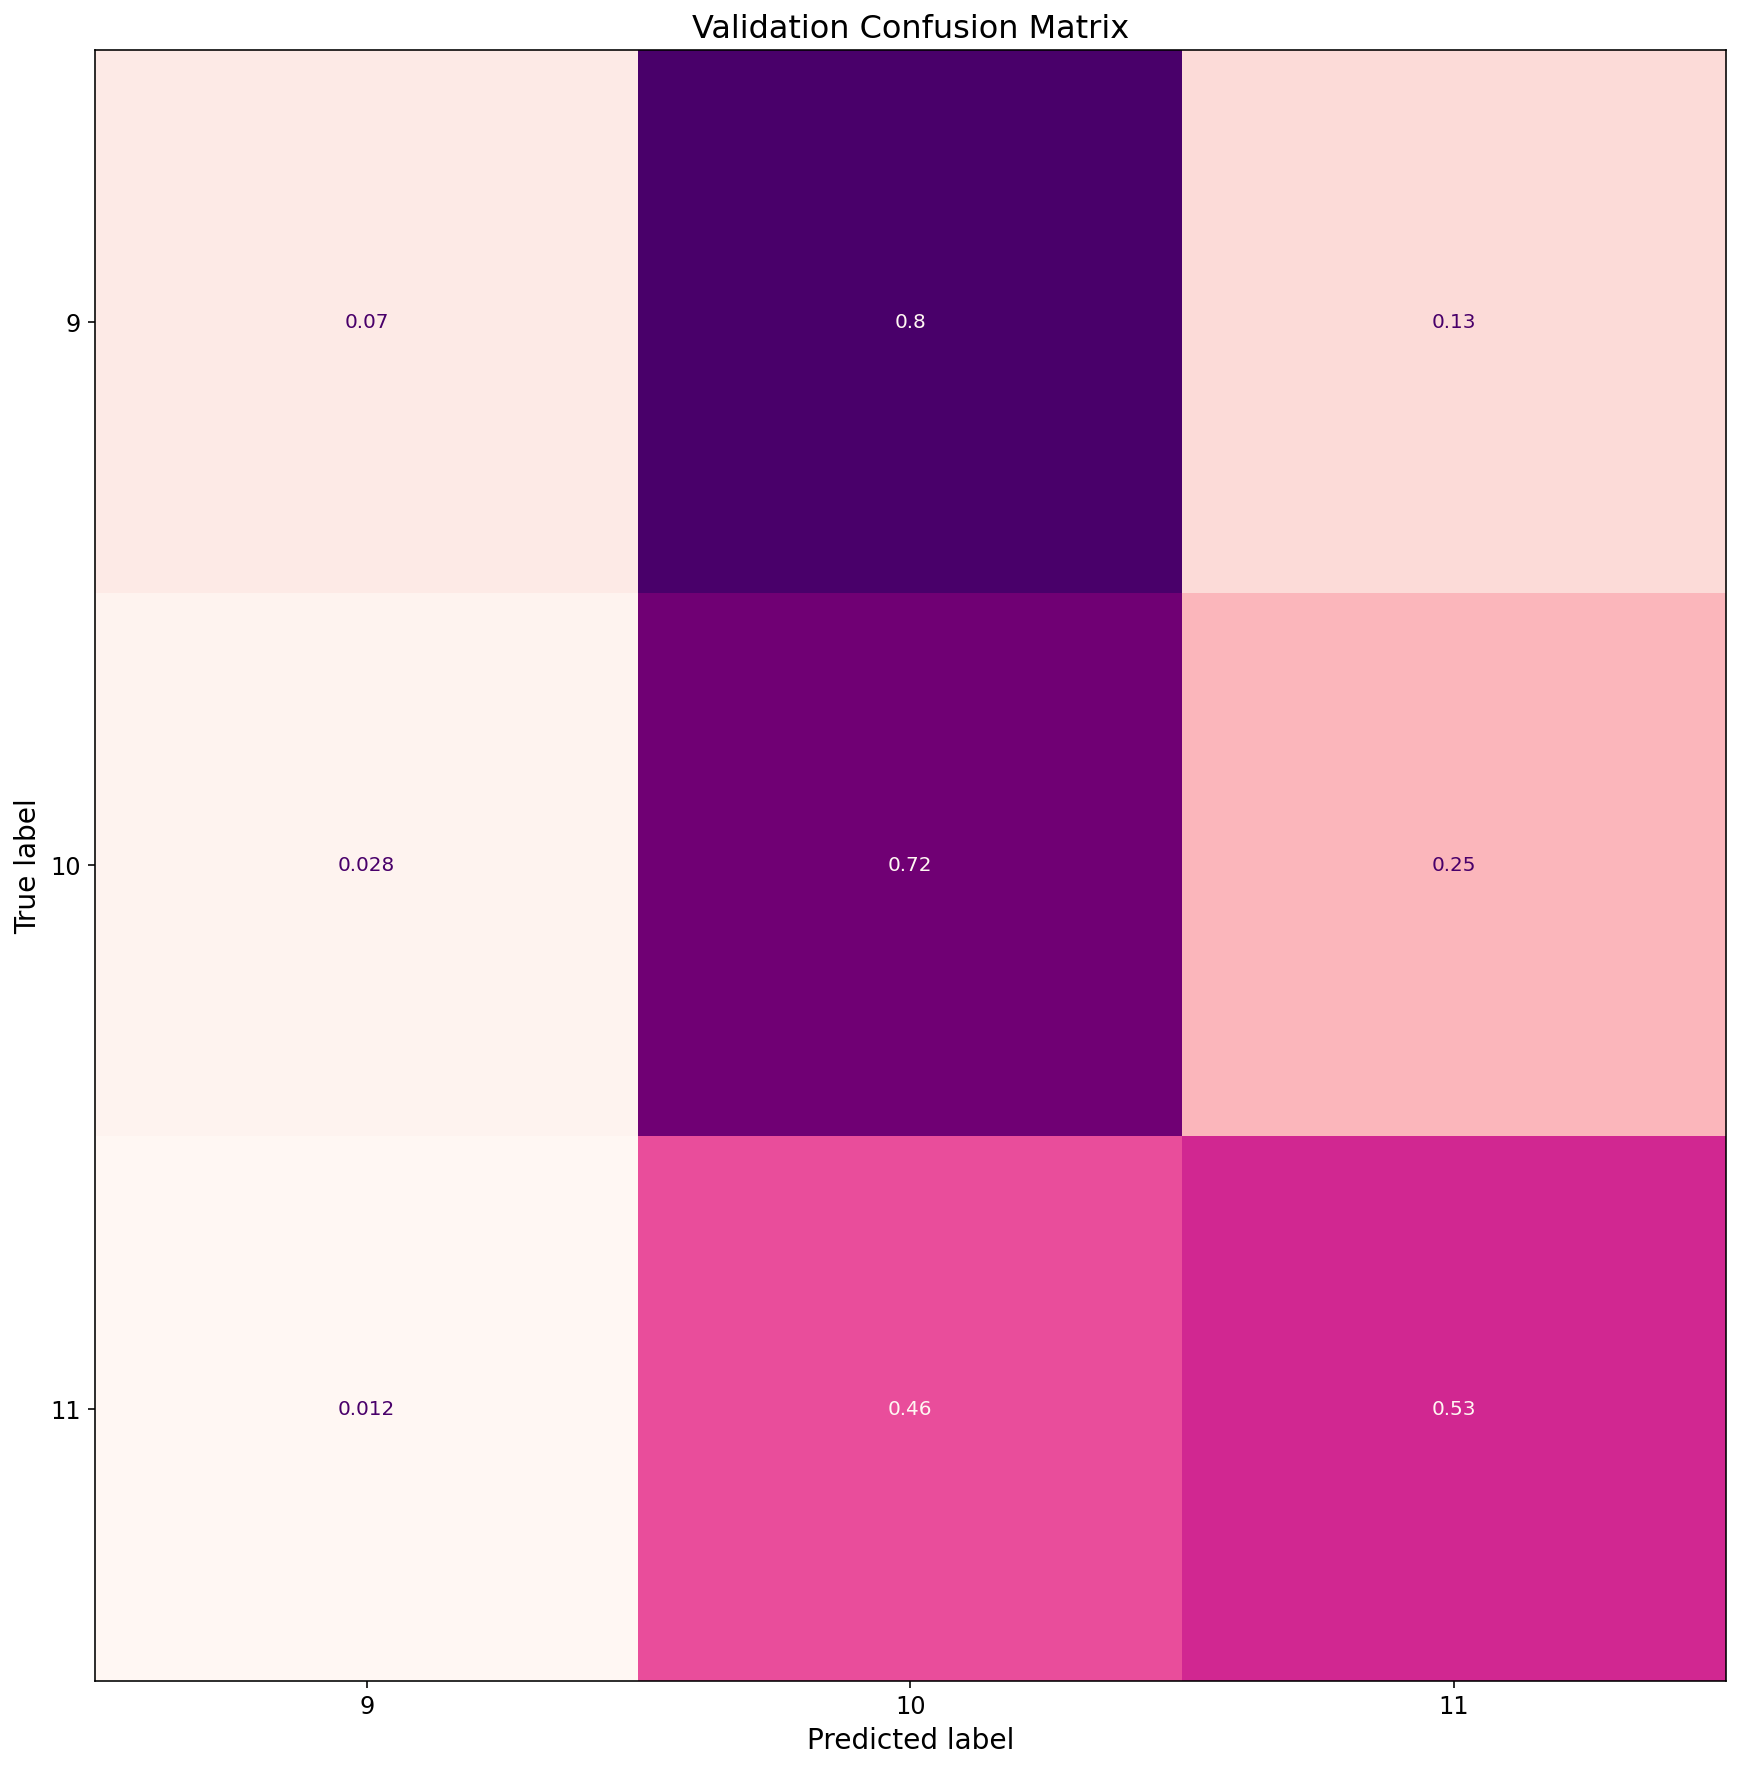

In [173]:
run_fasttext(new_train.loc[new_train[(new_train['grade_reduced'] >= 9) & (new_train['grade_reduced'] < 12)].index, :],
             new_val.loc[new_val[(new_val['grade_reduced'] >= 9) & (new_val['grade_reduced'] < 12)].index, :],
             new_test.loc[new_test[(new_test['grade_reduced'] >= 9) & (new_test['grade_reduced'] < 12)].index, :],
             'grade_reduced', 
             ['lemmatized_text_combined'],
             confusion_matrix = 'val',
             autotune = True);

Similar results as to the reduction of classes above, with still 5% increase in accuracy from the null, and a smaller MAE than other models simply due to a reduction in total possible distance, but very much on par with the null.

### Classification by Class Groups
Now comes the fun part! There are several ways we can break up the classes into groups. Based on the performance of the models so far, and the similarity seen between classes in eda, my proposal is:
- Easy: 5.0 - 5.8
- Intermediate: 5.9-5.11
- Difficult: 5.12-5.15

These are based partially on eda, partially on [this grouping of ratings](https://www.rei.com/learn/expert-advice/climbing-bouldering-rating.html) by REI, and partially on the performance of the model so far and the ways that it has mis-classified the various classes. This does group a majority of our data in one class still (5.9-5.11), but the difficult and intermediate classes should still have a good number of rows. Initially two classes were proposed for the easy class, splitting it into 5.0-5.4 and 5.5-5.8, but the class imbalances were too deep, so they had to be combined.

In [6]:
#make a grade group target column
for df in (new_train, new_val, new_test):
    df['grade_group'] = df['grade_reduced'].apply(lambda x: 0 if x < 9 else (1 if x < 12 else 2))

new_train['grade_group'].value_counts(normalize=True)

1    0.586924
0    0.270741
2    0.142335
Name: grade_group, dtype: float64

In [191]:
#grouped null mae
mean_absolute_error(new_train['grade_group'],
                    np.full_like(new_train['grade_group'], 1))

0.4130764886741545

This class imbalance is still quite extreme, but we're going to give it a try.

Progress: 100.0% Trials:   13 Best score:  0.686282 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  53112
Number of labels: 3
Progress: 100.0% words/sec/thread:  868208 lr:  0.000000 avg.loss:  0.332617 ETA:   0h 0m 0s


Train Accuracy:		99.6%
Validation Accuracy:	68.3%
Test Accuracy:		68.8%
Test MAE:		0.32


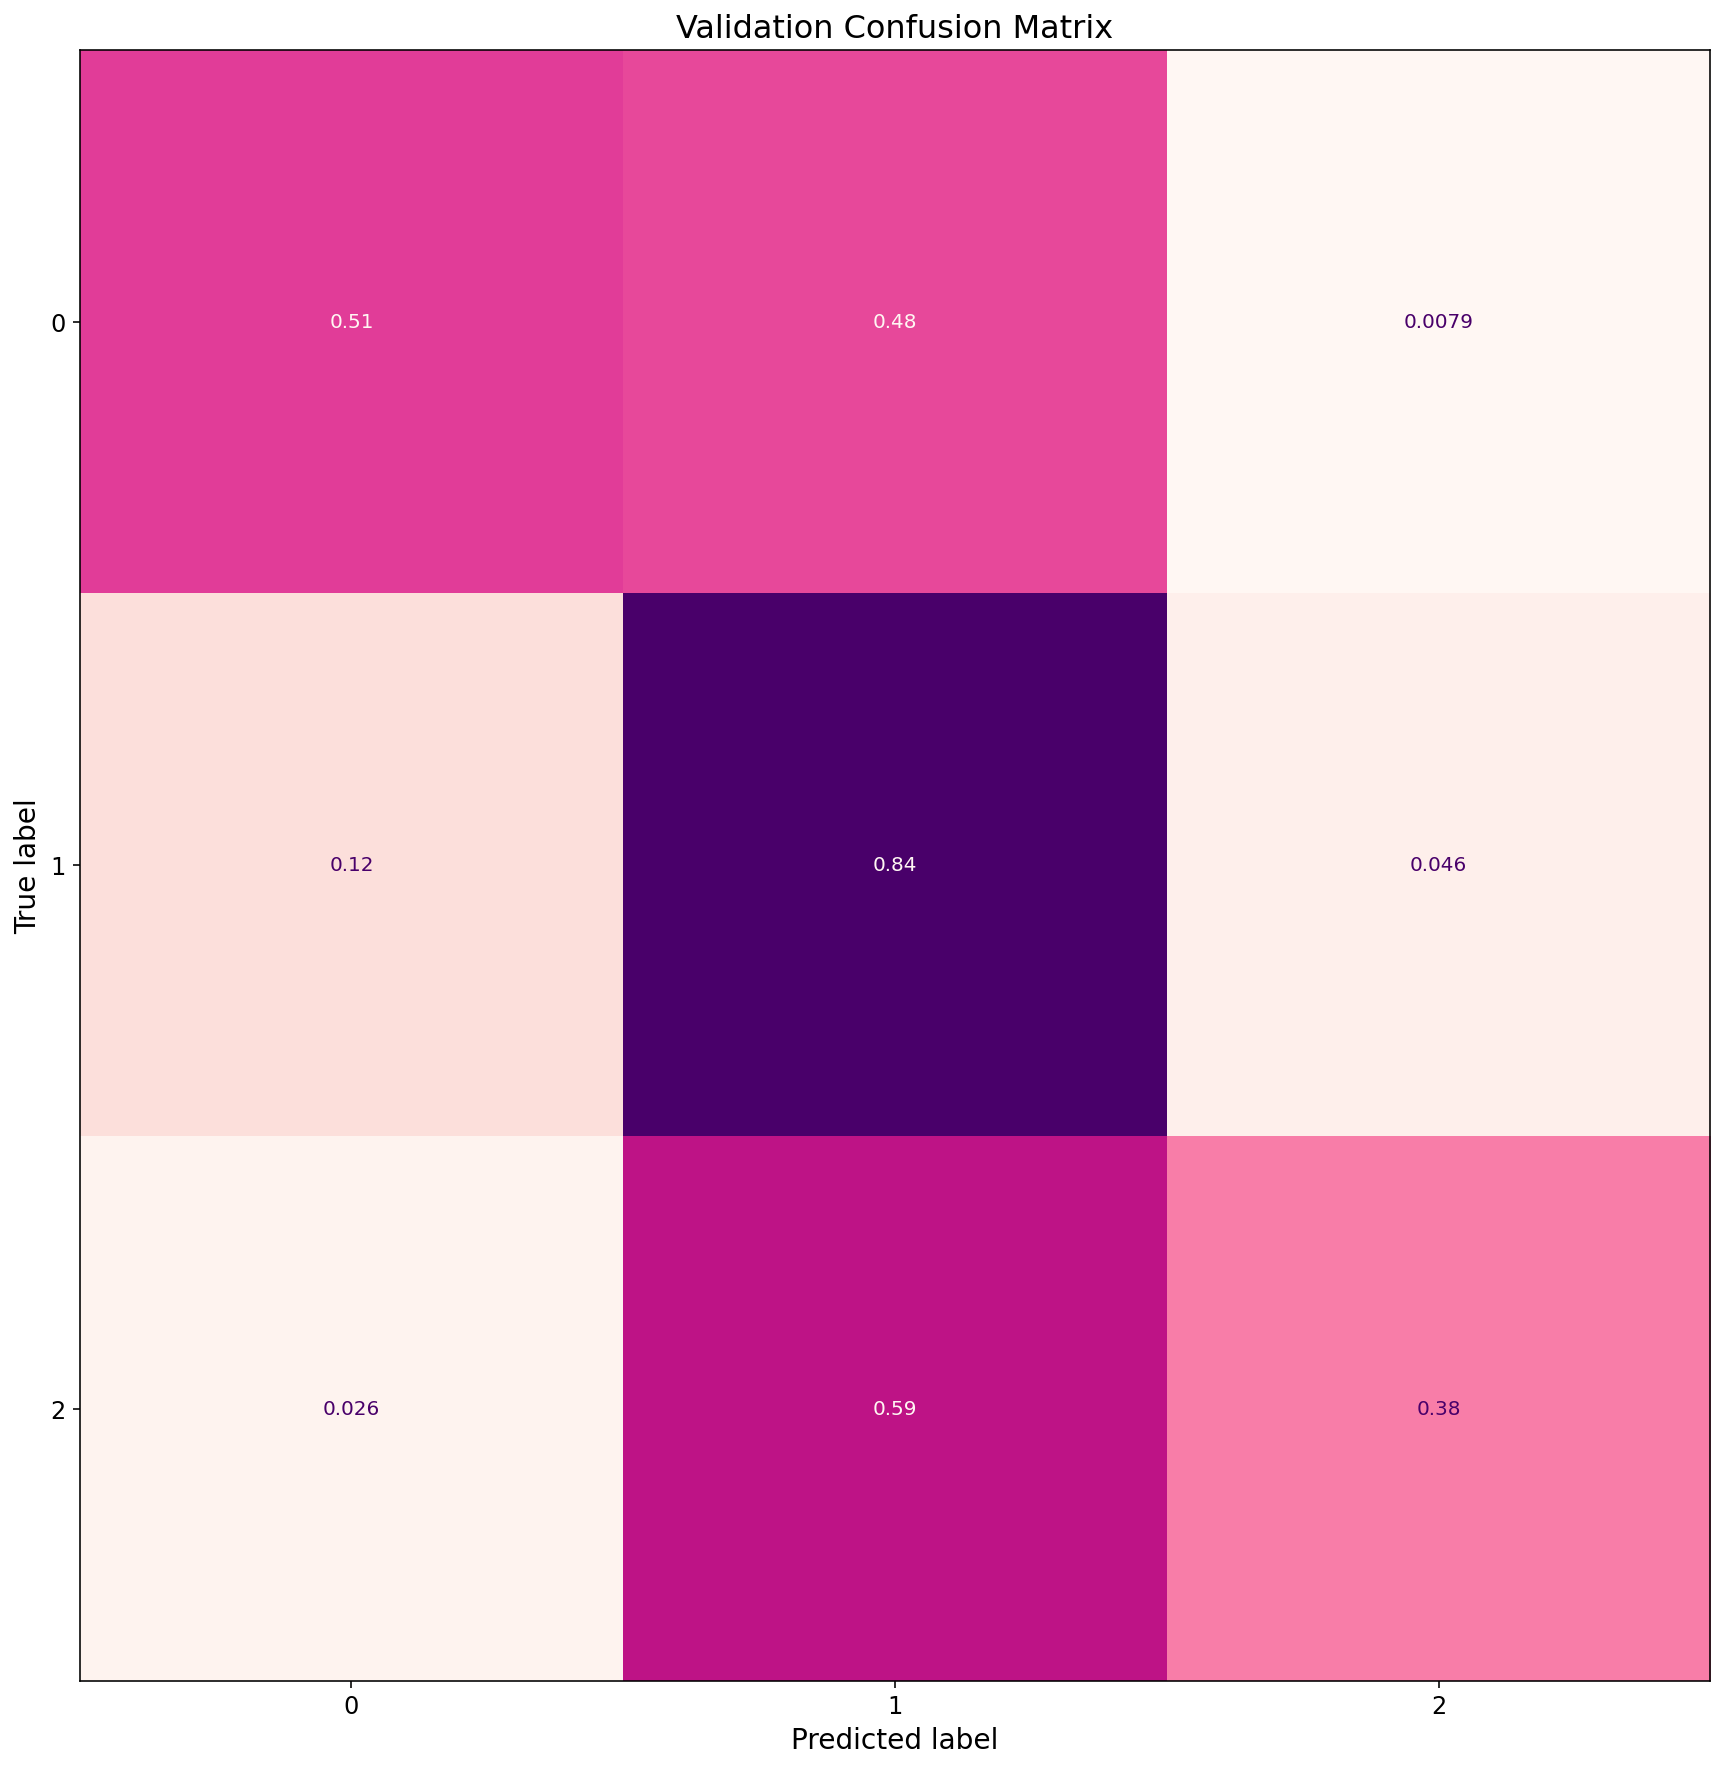

In [181]:
run_fasttext(new_train, new_val, new_test, 'grade_group', ['lemmatized_text_combined'], autotune=True, confusion_matrix='val');

Here we see finally some improvement in model performance! True, there is a fair amount of overfitting, but unlike in previous examples, that overfitting is also leading to improvements in the validation and testing. This is a promising change in the distribution of predictions. I tried random undersampling of the majority class one last time, but the model performed exactly as the null, predicting only the majority class. Therefore, the above will be our last model. With a test MAE of .32 and accuracy 10% above the null, this model performed best of any tried, although the increase in accuracy between null and predicted is proportional to the difference betwen null accuracy for the models with more classes and the model with only three. No significant model improvements were found during the modeling process, and I would not use these models for any type of inference or in production settings.

## Conclusions and Future Work
This dataset proved to be far more tricky to work with than anticipated, especially the deep class imbalances. The intuition I had going into it was that manipulation of the text itself would have noticeable positive effects on the modeling outcomes, but the variety of cleaning methods I tried had essentially no effect. Same for addition of features from other columns within the dataset. The only noteworthy change we saw was when the number of classes was greatly reduced, and this improvement for the most part was an artifact of reducing the amount of "wrong" the model could be. The only exception is the final grouping, in which we reduced to 3 groups: easy, intermediate, and difficult. These groupings played to the strength of the model, while also highlighting potential clustering we saw during EDA. 

Ultimately, what this process has shown us is that there is likely no significant difference in the way that routes of different grades are described. However, further methods should be explored.

### Future Work and Other Approaches
There are a multitude of other approaches we could take toward this dataset. The number one factor we're missing in this analysis is an investigation into the similarity of the descriptions across grades. In retrospect, this should have been one of the first steps, but the author got too caught up in implementing the various potential models, which ended up being more time-consuming than expected.

Exploration of vector similarity of text features can be done using word2vec or spaCy vectors and their inbuilt vectorizers and similarity functions. Clustering could then be done using these word vectors, which would give us another indication of if descriptions naturally group by grade or group instead by some confounding factor, such as type, area, year established, etc. This is a [tutorial](https://www.analyticsvidhya.com/blog/2022/01/from-word-embedding-to-documents-embedding-without-any-training/) showing the use of [gensim's FastText model](https://radimrehurek.com/gensim/models/fasttext.html) for a similar task. Zooming out a little, we can also use doc2vec to compute sentence similarity, which may perform better than fastText or word2vec. The power of fastText and spaCy are really in the way that they can identify subwords as well as the usual tokens, which is not a tool we used for this task. [Doc2vec is meant for examining whole documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd), and may be a better fit for the problem at hand. Many vectorization and document similarity techniques [exist](https://medium.com/@adriensieg/text-similarities-da019229c894), and the optimal solution for this problem would take some more research (and potentially notebook iterations) to discover.

Building on document vectors and similarity, we would be able to use document similarity by grade to reduce duplicate data, as explained in [this article](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8). This is a much more effective way of subsampling than random subsampling because it reduces the possibility of data loss. This method would be targeted toward the majority classes.

As an alternative to a focus on document-level embedding, we could try exploration of up-weighting or increasing the importance of domain-specific terms. This corpus has quite an array of out-of-vocabulary terms that could potentially be highlighted to draw out distinctions between classes. This was the goal of the scrapped Multinomial Naive Bayes implementation using the TF-IDF vectorizer, but a more sophisticated approach that utilizes the neural network tools at hand would be interesting. 



I would also like to explore more transfer learning options. Most of the models we've discussed so far have transfer learning options, including the version of fastText that was implemented. Transfer learning with BERT proved to be unsuccessful, but perhaps other methods would have more success.

Finally, I am interested in the implementation of an ensemble of models, as suggested by instructor BingYune Chen. As another way to address class imbalances, we could use a model similar to the final one to predict if a row belongs to a certain group of classes, and then sub-predict class from there. This sort of ensemble would reduce the affect of the oversized majority class on the minority classes. One roadblock on the path to this implementation would be first building a model that predicts class groups more reliably than what we have been able to create so far. 